In [ ]:
import os
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (6,4)


CSV_PATH = "dataset/kidneyData.csv"
df = pd.read_csv(CSV_PATH)
df.head()



In [ ]:
from pathlib import Path


# Example relative path:
DATA_ROOT = Path("D:/Products/kidney-main/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")

print("DATA_ROOT =", DATA_ROOT)

print("Exists? ->", DATA_ROOT.exists())

def jpg_count(p: Path):
    return len(list(p.glob("*.jpg"))) + len(list(p.glob("*.jpeg"))) + len(list(p.glob("*.png")))

for cls in ["Cyst","Normal","Stone","Tumor"]:
    p = DATA_ROOT / cls
    print(f"{cls:6} | exists: {p.exists():5} | images: {jpg_count(p) if p.exists() else 0}")


In [ ]:

EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

rows = []
for cls in ["Cyst", "Normal", "Stone", "Tumor"]:
    class_dir = DATA_ROOT / cls
    if not class_dir.exists():
        print(f"⚠️ Missing folder: {class_dir}")
        continue
    for f in class_dir.rglob("*"):
        if f.suffix.lower() in EXTS and f.is_file():
            rows.append({
                "Class": cls,
                "image_id": f.stem,       # filename without extension
                "local_path": str(f)
            })

file_index = pd.DataFrame(rows)
print("Indexed images:", file_index.shape[0])
file_index.head()


In [ ]:
import re

def norm(s):
    """Normalize strings for safe matching."""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)   
    return s


df["_image_id_norm"] = df["image_id"].map(norm)
df["_class_norm"]    = df["Class"].map(norm)

file_index["_image_id_norm"] = file_index["image_id"].map(norm)
file_index["_class_norm"]    = file_index["Class"].map(norm)


merged = pd.merge(
    df, 
    file_index[["_image_id_norm", "_class_norm", "local_path"]],
    on=["_image_id_norm","_class_norm"],
    how="inner"
)

print(f"Matched {merged.shape[0]} / {df.shape[0]} rows")
merged.head()


In [ ]:

counts = merged["Class"].value_counts().rename_axis("Class").reset_index(name="count")
print(counts)

plt.figure()
plt.bar(counts["Class"], counts["count"])
plt.title("Class Distribution (resolved paths)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

N = 600  # adjust for speed
dims = []

subset = merged.sample(min(N, len(merged)), random_state=42)

for p in subset["local_path"]:
    try:
        with Image.open(p) as im:
            w, h = im.size
            dims.append((w, h))
    except:
        pass

dims_df = pd.DataFrame(dims, columns=["Width","Height"])
print(dims_df.describe())

plt.figure()
plt.scatter(dims_df["Width"], dims_df["Height"])
plt.title("Image Dimension Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(dims_df["Width"] / dims_df["Height"], bins=30)
plt.title("Aspect Ratio (W/H)")
plt.xlabel("W/H")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [ ]:
def show_class_samples(df_with_paths, per_class=4):
    classes = sorted(df_with_paths["Class"].unique())
    cols = per_class
    rows = len(classes)
    plt.figure(figsize=(max(6, 3*cols), max(4, 3*rows)))

    idx = 1
    for cls in classes:
        sub = df_with_paths[df_with_paths["Class"] == cls].head(per_class)
        for _, r in sub.iterrows():
            try:
                with Image.open(r["local_path"]) as im:
                    plt.subplot(rows, cols, idx)
                    plt.imshow(im)
                    plt.axis("off")
                    plt.title(cls)
                    idx += 1
            except:
                pass
    plt.tight_layout()
    plt.show()

show_class_samples(merged, per_class=4)


In [ ]:

clean_df = merged.dropna(subset=["local_path"]).copy()
clean_df.reset_index(drop=True, inplace=True)

print("Final dataset shape:", clean_df.shape)
print(clean_df.head())


clean_df.to_csv("kidney_resolved_paths.csv", index=False)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class KidneyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["local_path"]
        label = int(row["target"])   # target column from CSV
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Create dataset + loader
dataset = KidneyDataset(clean_df, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Test one batch
images, labels = next(iter(dataloader))
print("Batch images shape:", images.shape)
print("Batch labels shape:", labels.shape)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Simple CNN for classification
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),  # 224→28 after 3 poolings
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


num_classes = len(clean_df["target"].unique())
model = SimpleCNN(num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")



In [ ]:
from torch.utils.data import random_split
from tqdm import tqdm

train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


epochs = 20  # adjust
for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total


    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    # Epoch summary
    print(f"Epoch {epoch+1}/{epochs} "
          f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


# Again training with proper splits and augmentations

In [ ]:
from torch.utils.data import random_split
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


total_size = len(clean_df)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_df, val_df, test_df = random_split(clean_df, [train_size, val_size, test_size])


train_dataset = KidneyDataset(train_df.dataset.iloc[train_df.indices], transform=train_transform)
val_dataset   = KidneyDataset(val_df.dataset.iloc[val_df.indices], transform=val_test_transform)
test_dataset  = KidneyDataset(test_df.dataset.iloc[test_df.indices], transform=val_test_transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reset model (fresh weights)
model = SimpleCNN(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Store history
train_losses, val_losses = [], []
train_accs, val_accs = [], []

epochs = 5  # adjust as needed
for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total

    # Save history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} "
          f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# --- Plot curves ---
epochs_range = range(1, epochs+1)
plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader, device)
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# --- Evaluate on test set and collect predictions ---
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Overall accuracy ---
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_acc = 100. * (all_preds == all_labels).sum() / len(all_labels)
print(f"✅ Final Test Accuracy: {test_acc:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
class_names = sorted(clean_df["Class"].unique())

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


In [ ]:
import random

def show_predictions(model, dataset, class_names, n=12):
    model.eval()
    indices = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices, 1):
        image, label = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, pred = output.max(1)

        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * 0.5) + 0.5   # de-normalize from [-1,1] to [0,1]

        plt.subplot(3, 4, i)
        plt.imshow(image_np)
        plt.axis("off")
        true_lbl = class_names[label]
        pred_lbl = class_names[pred.item()]
        color = "green" if true_lbl == pred_lbl else "red"
        plt.title(f"T:{true_lbl}\nP:{pred_lbl}", color=color)

    plt.tight_layout()
    plt.show()

# Class names from dataset
class_names = sorted(clean_df["Class"].unique())

# Show predictions on test set
show_predictions(model, test_dataset, class_names, n=12)


In [ ]:

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm  

class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: torch.nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None


        self.fh = target_layer.register_forward_hook(self._save_activation)


        try:
            self.bh = target_layer.register_full_backward_hook(self._save_gradient)
        except Exception:

            self.bh = target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        # out: [B, C, H, W]
        self.activations = out.detach()

    def _save_gradient(self, module, grad_in, grad_out):
        # grad_out[0]: [B, C, H, W]
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor: torch.Tensor, class_idx: int | None = None) -> np.ndarray:
        """
        input_tensor: (1, C, H, W) on the same device as model
        returns: heatmap (H, W) in [0, 1]
        """

        self.gradients = None
        self.activations = None

        output = self.model(input_tensor)  # (1, num_classes)
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())


        self.model.zero_grad(set_to_none=True)
        loss = output[0, class_idx]
        loss.backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("GradCAM hooks did not capture gradients/activations. "
                               "Check the target layer reference.")

        # weights: channel-wise mean of gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
        cam = (weights * self.activations).sum(dim=1).squeeze(0)  # (H, W)

        # ReLU + normalize to [0,1]
        cam = torch.clamp(cam, min=0)
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().numpy()
gradcam = GradCAM(model, model.features[-3])

def _denorm(img_tensor: torch.Tensor) -> np.ndarray:
    # assumes (img-0.5)/0.5 normalization
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    return np.clip((img * 0.5) + 0.5, 0, 1)

def _apply_cmap(hm01: np.ndarray, cmap: str = "jet") -> np.ndarray:
    rgba = mpl_cm.get_cmap(cmap)(hm01)  # (H,W,4)
    return rgba[..., :3]                # (H,W,3) in [0,1]

def overlay_topk(img_tensor: torch.Tensor, heatmap01: np.ndarray,
                 k: float = 0.90, alpha: float = 0.6, cmap: str = "jet") -> np.ndarray:
    """
    Overlay only the top (1-k) fraction of the heatmap onto the de-normalized image.
    k=0.90 -> keep top 10% hottest pixels.
    """
    img = _denorm(img_tensor)
    H, W, _ = img.shape
    hm = cv2.resize(heatmap01, (W, H), interpolation=cv2.INTER_LINEAR)

    thr = np.quantile(hm, k)
    mask = (hm >= thr).astype(np.float32)[..., None]  # (H,W,1)

    hm_rgb = _apply_cmap(hm, cmap=cmap)               # (H,W,3) in [0,1]
    a = alpha * mask                                   # alpha only on hot pixels
    out = (1 - a) * img + a * hm_rgb
    return np.clip(out, 0, 1)

def show_gradcam(model, dataset, class_names, n: int = 10, k: float = 0.90, cmap: str = "jet"):
    model.eval()
    import random
    n = min(n, len(dataset))
    indices = random.sample(range(len(dataset)), n)
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(3.2 * cols, 3.6 * rows))

    for i, idx in enumerate(indices, 1):
        img_tensor, label = dataset[idx]
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_idx = int(logits.argmax(1).item())

        hm = gradcam.generate(img_tensor.unsqueeze(0).to(device), class_idx=pred_idx)
        overlay = overlay_topk(img_tensor, hm, k=k, alpha=0.6, cmap=cmap)

        plt.subplot(rows, cols, i)
        plt.imshow(overlay)
        plt.axis("off")
        t = class_names[label]
        p = class_names[pred_idx]
        plt.title(f"T:{t}  P:{p}", color=("green" if t == p else "red"), fontsize=10)

    plt.tight_layout()
    plt.show()

# example run
show_gradcam(model, test_dataset, class_names, n=10, k=0.90, cmap="jet")


In [ ]:
import os, random, csv, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import cm as mpl_cm  # colormaps: 'jet', 'magma', 'inferno', 'viridis', ...


N = 24          # how many samples to export
TOPK = 0.90     # keep only the top (1 - TOPK) fraction of heatmap (e.g., 0.90 -> top 10%)
CMAP = "jet"    # colormap
ALPHA = 0.6     # overlay strength
OUT_DIR = Path("gradcam_outputs_fixed")
# ---------------------------

OUT_DIR.mkdir(parents=True, exist_ok=True)

def denorm_img(img_tensor):
    """De-normalize from (img-0.5)/0.5 back to [0,1]."""
    img = img_tensor.permute(1,2,0).cpu().numpy()
    return np.clip((img * 0.5) + 0.5, 0, 1)

def apply_colormap(hm01, cmap=CMAP):
    """Convert [0,1] heatmap -> RGB image."""
    rgba = mpl_cm.get_cmap(cmap)(hm01)  # (H,W,4)
    return rgba[..., :3]

def overlay_topk(img01, hm01, k=TOPK, alpha=ALPHA, cmap=CMAP):
    """Overlay only top-(1-k) heatmap onto image."""
    H, W, _ = img01.shape
    hm = cv2.resize(hm01, (W, H), interpolation=cv2.INTER_LINEAR)

    thr = np.quantile(hm, k)
    mask = (hm >= thr).astype(np.float32)[..., None]

    hm_rgb = apply_colormap(hm, cmap=cmap)
    a = alpha * mask
    out = (1 - a) * img01 + a * hm_rgb
    return np.clip(out, 0, 1)

def save_gradcam_pair(img_tensor, heatmap01, true_lbl, pred_lbl, out_path, cmap="jet"):
    img = denorm_img(img_tensor)
    overlay = overlay_topk(img, heatmap01, k=0.90, cmap=cmap, alpha=0.6)

    fig, axes = plt.subplots(1, 2, figsize=(9,4))
    axes[0].imshow(img, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(f"Original\nT:{true_lbl}")

    im = axes[1].imshow(overlay)
    axes[1].axis("off")
    axes[1].set_title(f"Grad-CAM\nP:{pred_lbl}")

    # add colorbar for heatmap intensity
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
    hm_display = plt.cm.get_cmap(cmap)(heatmap01)  # just the raw heatmap
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax)
    cbar.set_label("Importance (0→low, 1→high)")

    plt.tight_layout(rect=[0,0,0.9,1])
    plt.savefig(out_path, dpi=150)
    plt.close()


# ------- Generate & save -------
indices = random.sample(range(len(test_dataset)), min(N, len(test_dataset)))
csv_path = OUT_DIR / "gradcam_predictions.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["index_in_test", "true_label", "pred_label", "saved_image", "cmap", "topk"])
    for i, idx in enumerate(indices):
        img_tensor, true_idx = test_dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(input_tensor)
            pred_idx = int(out.argmax(1).item())

        hm01 = gradcam.generate(input_tensor, class_idx=pred_idx)
        true_lbl = class_names[true_idx]
        pred_lbl = class_names[pred_idx]

        outfile = OUT_DIR / f"gradcam_{i:03d}_T-{true_lbl}_P-{pred_lbl}.png"
        save_gradcam_pair(img_tensor, hm01, true_lbl, pred_lbl, outfile)

        writer.writerow([idx, true_lbl, pred_lbl, str(outfile), CMAP, TOPK])

print(f"✅ Saved {len(indices)} Grad-CAM images to: {OUT_DIR}")
print(f"📄 CSV with labels: {csv_path}")


In [ ]:
# ==== ResNet-18 fine-tuning on Kidney CT ====
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# --- 0) Dataset wrapper (re-use your CSV/DataFrame) ---
class KidneyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["local_path"]
        label = int(row["target"])
        from PIL import Image
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

# Safety check
assert "local_path" in clean_df.columns and "target" in clean_df.columns and "Class" in clean_df.columns, \
    "clean_df must contain columns: local_path, target, Class"

num_classes = clean_df["target"].nunique()

# --- 1) Stratified splits (70/15/15) ---
train_df, temp_df = train_test_split(
    clean_df, test_size=0.30, stratify=clean_df["target"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["target"], random_state=42
)

print(f"Split sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# --- 2) ImageNet transforms (match pretrained weights) ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_ds = KidneyDataset(train_df, transform=train_tfms)
val_ds   = KidneyDataset(val_df,   transform=eval_tfms)
test_ds  = KidneyDataset(test_df,  transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- 3) Model: ResNet-18 pretrained + new classification head ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # replace head
model = model.to(device)

# Option: different LR for backbone vs head
optimizer = optim.Adam([
    {"params": model.fc.parameters(), "lr": 3e-4},
    {"params": [p for n,p in model.named_parameters() if not n.startswith("fc.")], "lr": 1e-4},
])
criterion = nn.CrossEntropyLoss()

# --- 4) Training loop with progress & validation ---
def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False, desc="Train" if train else "Val")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        if train: optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

epochs = 10  # adjust
best_val_acc = 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader,   train=False)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
          f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}%")

    # simple checkpoint on best val acc
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "resnet18_kidney_best.pth")

print(f"Best Val Acc: {best_val_acc:.2f}%")

# --- 5) Final test evaluation ---
model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
model.eval()
test_correct, test_total, test_loss = 0, 0, 0.0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        test_total += labels.size(0)
        test_correct += preds.eq(labels).sum().item()
test_loss /= len(test_loader)
test_acc = 100.0 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# Optional: quick plots (loss/acc)
import matplotlib.pyplot as plt
ep = range(1, epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ep, history["train_loss"], label="Train")
plt.plot(ep, history["val_loss"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(ep, history["train_acc"], label="Train")
plt.plot(ep, history["val_acc"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
# ==== ResNet-18 fine-tuning (Windows-safe) ====
import os, platform, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Dataset wrapper ---
class KidneyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["local_path"]
        label = int(row["target"])
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

# Safety check
assert "local_path" in clean_df.columns and "target" in clean_df.columns, \
    "clean_df must contain columns: local_path, target"

num_classes = clean_df["target"].nunique()

# --- Stratified splits (70/15/15) ---
train_df, temp_df = train_test_split(
    clean_df, test_size=0.30, stratify=clean_df["target"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["target"], random_state=42
)

print(f"Split sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# --- ImageNet transforms ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

train_ds = KidneyDataset(train_df, transform=train_tfms)
val_ds   = KidneyDataset(val_df,   transform=eval_tfms)
test_ds  = KidneyDataset(test_df,  transform=eval_tfms)

# --- Safe DataLoader (Windows fix) ---
def make_loader(ds, batch_size=32, shuffle=False):
    on_windows = platform.system().lower().startswith("win")
    num_workers = 0 if on_windows else 2
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=torch.cuda.is_available())

train_loader = make_loader(train_ds, batch_size=32, shuffle=True)
val_loader   = make_loader(val_ds, batch_size=32)
test_loader  = make_loader(test_ds, batch_size=32)

# --- Model: ResNet-18 pretrained ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

optimizer = optim.Adam([
    {"params": model.fc.parameters(), "lr": 3e-4},
    {"params": [p for n,p in model.named_parameters() if not n.startswith("fc.")], "lr": 1e-4},
])
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# --- Training loop ---
def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, leave=False, desc="Train" if train else "Val")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        if train: optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            if train:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return running_loss / max(1,len(loader)), 100.0 * correct / max(1,total)

# --- Train ---
epochs, best_val_acc = 10, 0.0
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, epochs+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss); history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d}/{epochs} | Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | Val Loss {va_loss:.4f} Acc {va_acc:.2f}%")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "resnet18_kidney_best.pth")

print(f"✅ Best Val Acc: {best_val_acc:.2f}%")

# --- Final test evaluation ---
model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        test_total += labels.size(0)
        test_correct += preds.eq(labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100.0 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

# --- Plots ---
ep = range(1, epochs+1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(ep, history["train_loss"], label="Train"); plt.plot(ep, history["val_loss"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(ep, history["train_acc"], label="Train"); plt.plot(ep, history["val_acc"], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
# Grad-CAM with top-k overlay + colorbar (ResNet-18)
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm

# --- GradCAM core ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model, self.target_layer = model, target_layer
        self.gradients, self.activations = None, None
        self.fh = target_layer.register_forward_hook(self._save_activation)
        try:
            self.bh = target_layer.register_full_backward_hook(self._save_gradient)
        except Exception:
            self.bh = target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, m, i, o): self.activations = o.detach()
    def _save_gradient(self, m, gi, go): self.gradients = go[0].detach()

    def generate(self, x, class_idx=None):
        self.gradients = self.activations = None
        out = self.model(x)
        if class_idx is None:
            class_idx = int(out.argmax(1))
        self.model.zero_grad(set_to_none=True)
        out[0, class_idx].backward()
        w = self.gradients.mean(dim=(2,3), keepdim=True)          # (1,C,1,1)
        cam = (w * self.activations).sum(dim=1).squeeze(0)        # (H,W)
        cam = torch.clamp(cam, min=0)
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().numpy()  # [0,1]

# init on ResNet last conv
target_layer = model.layer4[-1].conv2
gradcam = GradCAM(model, target_layer)

# --- helpers ---
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denorm_img(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    return np.clip(img * IMAGENET_STD + IMAGENET_MEAN, 0, 1)

def overlay_topk(img01, hm01, topk=0.90, alpha=0.6, cmap="jet"):
    H,W,_ = img01.shape
    hm = cv2.resize(hm01, (W, H), interpolation=cv2.INTER_LINEAR)
    thr = np.quantile(hm, topk)
    mask = (hm >= thr).astype(np.float32)[..., None]
    hm_rgb = mpl_cm.get_cmap(cmap)(hm)[...,:3]  # [0,1]
    a = alpha * mask
    return np.clip((1-a)*img01 + a*hm_rgb, 0, 1), hm  # return overlay and full heatmap for colorbar

def show_gradcam_resnet(dataset, class_names, n=8, topk=0.90, cmap="jet", use_true_class=False):
    model.eval()
    import random
    idxs = random.sample(range(len(dataset)), n)
    cols, rows = 4, int(np.ceil(n/4))
    fig = plt.figure(figsize=(4.0*cols+1.2, 4.2*rows))  # extra width for colorbar

    # colorbar axis
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cb = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=cax)
    cb.set_label("Importance (0→low, 1→high)")

    for i, idx in enumerate(idxs, 1):
        img_t, y = dataset[idx]
        x = img_t.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(x)
            pred = int(logits.argmax(1))
        cls_for_cam = int(y) if use_true_class else pred

        hm01 = gradcam.generate(x, class_idx=cls_for_cam)
        overlay, hm_full = overlay_topk(denorm_img(img_t), hm01, topk=topk, alpha=0.6, cmap=cmap)

        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(overlay)
        ax.axis("off")
        t, p = class_names[int(y)], class_names[pred]
        ax.set_title(f"T:{t}  P:{p}", color=("green" if t==p else "red"))

    plt.tight_layout(rect=[0,0,0.90,1])  # leave space for colorbar
    plt.show()

# run it
class_names = sorted(clean_df["Class"].unique())
show_gradcam_resnet(test_ds, class_names, n=8, topk=0.90, cmap="jet", use_true_class=False)


In [15]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm
from PIL import Image
import random
from pathlib import Path
import seaborn as sns

class EnhancedGradCAM:
    """Enhanced GradCAM implementation with better visualization options"""
    
    def __init__(self, model, target_layers=None):
        self.model = model
        self.target_layers = target_layers or self._get_default_layers()
        self.gradients = {}
        self.activations = {}
        self.handles = []
        self._register_hooks()
    
    def _get_default_layers(self):
        """Get default target layers based on model architecture"""
        if hasattr(self.model, 'features'):
            # For models with features (like your custom CNN)
            return {'features': self.model.features[-3]}  # Third from last conv layer
        elif hasattr(self.model, 'layer4'):
            # For ResNet models
            return {'layer4': self.model.layer4[-1].conv2}
        else:
            # Generic approach - find last conv layer
            conv_layers = []
            for name, module in self.model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    conv_layers.append((name, module))
            if conv_layers:
                return {conv_layers[-1][0]: conv_layers[-1][1]}
            else:
                raise ValueError("No convolutional layers found in the model")
    
    def _register_hooks(self):
        """Register forward and backward hooks"""
        def forward_hook(name):
            def hook(module, input, output):
                self.activations[name] = output.detach()
            return hook
        
        def backward_hook(name):
            def hook(module, grad_input, grad_output):
                if grad_output[0] is not None:
                    self.gradients[name] = grad_output[0].detach()
            return hook
        
        for name, layer in self.target_layers.items():
            fh = layer.register_forward_hook(forward_hook(name))
            bh = layer.register_full_backward_hook(backward_hook(name))
            self.handles.extend([fh, bh])
    
    def generate(self, input_tensor, class_idx=None, layer_name=None):
        """Generate GradCAM heatmap"""
        # Clear previous gradients and activations
        self.gradients.clear()
        self.activations.clear()
        
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        # Get the target layer
        if layer_name is None:
            layer_name = list(self.target_layers.keys())[0]
        
        if layer_name not in self.gradients or layer_name not in self.activations:
            raise RuntimeError(f"GradCAM hooks did not capture data for layer '{layer_name}'")
        
        gradients = self.gradients[layer_name]
        activations = self.activations[layer_name]
        
        # Calculate weights (global average pooling of gradients)
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        
        # Calculate weighted combination of activation maps
        cam = (weights * activations).sum(dim=1).squeeze(0)  # [H, W]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy(), class_idx
    
    def cleanup(self):
        """Remove hooks"""
        for handle in self.handles:
            handle.remove()

class GradCAMVisualizer:
    """Enhanced visualization for GradCAM results"""
    
    def __init__(self, mean=None, std=None):
        # Default to ImageNet normalization
        self.mean = mean or np.array([0.485, 0.456, 0.406])
        self.std = std or np.array([0.229, 0.224, 0.225])
    
    def denormalize_image(self, img_tensor):
        """Denormalize image tensor back to [0, 1] range"""
        if len(img_tensor.shape) == 4:  # batch dimension
            img_tensor = img_tensor.squeeze(0)
        
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        
        # Check if image is normalized with ImageNet stats
        if img.mean() < 0.1 and img.std() > 1:  # likely normalized
            img = img * self.std + self.mean
        else:
            # Assume normalization to [-1, 1] range
            img = (img * 0.5) + 0.5
        
        return np.clip(img, 0, 1)
    
    def create_heatmap_overlay(self, img, heatmap, alpha=0.6, colormap='jet', 
                             threshold_percentile=90):
        """Create overlay of heatmap on original image"""
        H, W = img.shape[:2]
        
        # Resize heatmap to match image dimensions
        if heatmap.shape != (H, W):
            heatmap_resized = cv2.resize(heatmap, (W, H), 
                                       interpolation=cv2.INTER_CUBIC)
        else:
            heatmap_resized = heatmap.copy()
        
        # Apply threshold to show only most important regions
        if threshold_percentile > 0:
            threshold = np.percentile(heatmap_resized, threshold_percentile)
            mask = heatmap_resized >= threshold
            heatmap_masked = heatmap_resized * mask
        else:
            heatmap_masked = heatmap_resized
            mask = np.ones_like(heatmap_resized, dtype=bool)
        
        # Apply colormap
        heatmap_colored = mpl_cm.get_cmap(colormap)(heatmap_masked)[:, :, :3]
        
        # Create overlay
        overlay = img.copy()
        overlay_mask = mask[..., None]  # Add channel dimension
        overlay = (1 - alpha * overlay_mask) * overlay + \
                 alpha * overlay_mask * heatmap_colored
        
        return np.clip(overlay, 0, 1), heatmap_masked
    
    def plot_gradcam_results(self, model, gradcam, dataset, class_names, 
                           n_samples=8, cols=4, figsize_per_plot=(4, 4.5),
                           colormap='jet', alpha=0.6, threshold_percentile=90,
                           save_path=None, use_predicted_class=True):
        """Plot GradCAM results for multiple samples"""
        
        # Sample random indices
        indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
        rows = int(np.ceil(n_samples / cols))
        
        fig = plt.figure(figsize=(cols * figsize_per_plot[0] + 1.5, 
                                rows * figsize_per_plot[1]))
        
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        sm = plt.cm.ScalarMappable(cmap=colormap, 
                                  norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Activation Intensity', rotation=270, labelpad=15)
        
        for i, idx in enumerate(indices):
            img_tensor, true_label = dataset[idx]
            
            # Get model prediction
            with torch.no_grad():
                logits = model(img_tensor.unsqueeze(0).to(next(model.parameters()).device))
                pred_label = logits.argmax(dim=1).item()
            
            # Generate GradCAM
            cam_class = pred_label if use_predicted_class else true_label
            heatmap, _ = gradcam.generate(
                img_tensor.unsqueeze(0).to(next(model.parameters()).device),
                class_idx=cam_class
            )
            
            # Denormalize image
            img_denorm = self.denormalize_image(img_tensor)
            
            # Create overlay
            overlay, heatmap_masked = self.create_heatmap_overlay(
                img_denorm, heatmap, alpha=alpha, colormap=colormap,
                threshold_percentile=threshold_percentile
            )
            
            # Plot
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(overlay)
            ax.axis('off')
            
            # Title with true and predicted labels
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            color = 'green' if true_label == pred_label else 'red'
            title = f'True: {true_class}\nPred: {pred_class}'
            if use_predicted_class:
                title += f'\n(CAM for: {pred_class})'
            else:
                title += f'\n(CAM for: {true_class})'
            
            ax.set_title(title, color=color, fontsize=10)
        
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return indices  # Return indices for further analysis
    
    def compare_multiple_layers(self, model, gradcam, img_tensor, true_label, 
                              class_names, layers_to_compare=None):
        """Compare GradCAM results across different layers"""
        if layers_to_compare is None:
            layers_to_compare = list(gradcam.target_layers.keys())
        
        # Get prediction
        device = next(model.parameters()).device
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
        
        fig, axes = plt.subplots(2, len(layers_to_compare), 
                               figsize=(4 * len(layers_to_compare), 8))
        
        if len(layers_to_compare) == 1:
            axes = axes.reshape(-1, 1)
        
        img_denorm = self.denormalize_image(img_tensor)
        
        for i, layer_name in enumerate(layers_to_compare):
            # Generate GradCAM for this layer
            heatmap, _ = gradcam.generate(
                img_tensor.unsqueeze(0).to(device),
                class_idx=pred_label,
                layer_name=layer_name
            )
            
            # Original image
            axes[0, i].imshow(img_denorm)
            axes[0, i].set_title(f'Original\n{class_names[true_label]}')
            axes[0, i].axis('off')
            
            # GradCAM overlay
            overlay, _ = self.create_heatmap_overlay(
                img_denorm, heatmap, alpha=0.6, colormap='jet',
                threshold_percentile=85
            )
            axes[1, i].imshow(overlay)
            axes[1, i].set_title(f'GradCAM - {layer_name}\nPred: {class_names[pred_label]}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Usage example functions
def setup_gradcam_for_custom_cnn(model):
    """Setup GradCAM for your custom CNN model"""
    # Target the last convolutional layer in features
    target_layers = {'last_conv': model.features[-3]}  # Adjust index as needed
    return EnhancedGradCAM(model, target_layers)

def setup_gradcam_for_resnet(model):
    """Setup GradCAM for ResNet model"""
    target_layers = {
        'layer3': model.layer3[-1].conv2,  # Earlier layer
        'layer4': model.layer4[-1].conv2   # Final conv layer
    }
    return EnhancedGradCAM(model, target_layers)

def analyze_gradcam_quality(gradcam_results, threshold=0.1):
    """Analyze the quality of GradCAM results"""
    stats = {}
    for name, heatmap in gradcam_results.items():
        stats[name] = {
            'max_activation': np.max(heatmap),
            'mean_activation': np.mean(heatmap),
            'std_activation': np.std(heatmap),
            'coverage': np.mean(heatmap > threshold),  # Fraction of image activated
            'concentration': np.sum(heatmap > np.percentile(heatmap, 90)) / heatmap.size
        }
    return stats

# Example usage with your models
def run_enhanced_gradcam_analysis(model, test_dataset, class_names, model_type='resnet'):
    """Run comprehensive GradCAM analysis"""
    
    # Setup GradCAM based on model type
    if model_type == 'resnet':
        gradcam = setup_gradcam_for_resnet(model)
        # For ImageNet-normalized models
        visualizer = GradCAMVisualizer(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])
        )
    else:  # custom CNN
        gradcam = setup_gradcam_for_custom_cnn(model)
        # For [-1, 1] normalized models
        visualizer = GradCAMVisualizer(
            mean=np.array([0.5, 0.5, 0.5]),
            std=np.array([0.5, 0.5, 0.5])
        )
    
    print("🔍 Running GradCAM Analysis...")
    
    # Basic visualization
    print("\n1. Basic GradCAM Results:")
    indices = visualizer.plot_gradcam_results(
        model=model,
        gradcam=gradcam,
        dataset=test_dataset,
        class_names=class_names,
        n_samples=12,
        cols=4,
        threshold_percentile=85,  # Show top 15% activations
        use_predicted_class=True
    )
    
    # Compare different threshold percentiles
    print("\n2. Comparing Different Activation Thresholds:")
    sample_idx = indices[0]
    img_tensor, true_label = test_dataset[sample_idx]
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    thresholds = [70, 80, 90, 95]
    
    for i, thresh in enumerate(thresholds):
        device = next(model.parameters()).device
        heatmap, pred_class = gradcam.generate(
            img_tensor.unsqueeze(0).to(device)
        )
        
        img_denorm = visualizer.denormalize_image(img_tensor)
        overlay, _ = visualizer.create_heatmap_overlay(
            img_denorm, heatmap, alpha=0.6, 
            threshold_percentile=thresh
        )
        
        axes[i].imshow(overlay)
        axes[i].set_title(f'Top {100-thresh}% activations')
        axes[i].axis('off')
    
    plt.suptitle(f'Threshold Comparison - {class_names[true_label]}')
    plt.tight_layout()
    plt.show()
    
    # Cleanup
    gradcam.cleanup()
    
    return gradcam, visualizer

# Advanced analysis functions
def save_gradcam_batch(model, gradcam, visualizer, dataset, class_names, 
                      output_dir, n_samples=50):
    """Save a batch of GradCAM results for detailed analysis"""
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    device = next(model.parameters()).device
    indices = random.sample(range(len(dataset)), min(n_samples, len(dataset)))
    
    results = []
    
    for i, idx in enumerate(indices):
        img_tensor, true_label = dataset[idx]
        
        # Get prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            confidence = F.softmax(logits, dim=1).max().item()
        
        # Generate GradCAM
        heatmap, _ = gradcam.generate(img_tensor.unsqueeze(0).to(device))
        
        # Create visualization
        img_denorm = visualizer.denormalize_image(img_tensor)
        overlay, heatmap_masked = visualizer.create_heatmap_overlay(
            img_denorm, heatmap, alpha=0.6, threshold_percentile=85
        )
        
        # Save image
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        
        axes[0].imshow(img_denorm)
        axes[0].set_title('Original')
        axes[0].axis('off')
        
        axes[1].imshow(heatmap, cmap='jet')
        axes[1].set_title('Heatmap')
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title('Overlay')
        axes[2].axis('off')
        
        plt.suptitle(f'True: {class_names[true_label]} | '
                    f'Pred: {class_names[pred_label]} | '
                    f'Conf: {confidence:.3f}')
        
        save_path = output_path / f'gradcam_{i:03d}_{class_names[true_label]}_{class_names[pred_label]}.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        # Store results
        results.append({
            'idx': idx,
            'true_label': true_label,
            'pred_label': pred_label,
            'confidence': confidence,
            'correct': true_label == pred_label,
            'heatmap_max': np.max(heatmap),
            'heatmap_mean': np.mean(heatmap),
            'file_path': str(save_path)
        })
    
    # Save results summary
    import pandas as pd
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path / 'gradcam_results.csv', index=False)
    
    print(f"✅ Saved {len(results)} GradCAM results to {output_path}")
    return results_df

In [16]:
# Usage script for enhanced GradCAM with your kidney classification models
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming you've run the enhanced GradCAM code above

def main_gradcam_analysis():
    """Main function to run GradCAM analysis on your models"""
    
    # Load your best model (adjust path as needed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # For ResNet model
    if Path("resnet18_kidney_best.pth").exists():
        print("🔄 Loading ResNet-18 model...")
        from torchvision.models import resnet18
        import torch.nn as nn
        
        # Recreate model architecture
        model = resnet18(weights=None)
        num_classes = len(clean_df["target"].unique())
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
        # Load weights
        model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
        model = model.to(device)
        model.eval()
        
        print("✅ ResNet-18 model loaded successfully!")
        
        # Run GradCAM analysis for ResNet
        class_names = sorted(clean_df["Class"].unique())
        
        print("\n🎯 Starting ResNet GradCAM Analysis...")
        gradcam, visualizer = run_enhanced_gradcam_analysis(
            model=model,
            test_dataset=test_ds,  # Use your test dataset
            class_names=class_names,
            model_type='resnet'
        )
        
        # Advanced analysis: Compare layers
        print("\n🔍 Comparing Different Layers...")
        sample_img, sample_label = test_ds[0]
        
        # Setup GradCAM with multiple layers for comparison
        target_layers = {
            'layer2': model.layer2[-1].conv2,
            'layer3': model.layer3[-1].conv2,
            'layer4': model.layer4[-1].conv2
        }
        gradcam_multi = EnhancedGradCAM(model, target_layers)
        
        visualizer.compare_multiple_layers(
            model=model,
            gradcam=gradcam_multi,
            img_tensor=sample_img,
            true_label=sample_label,
            class_names=class_names,
            layers_to_compare=['layer2', 'layer3', 'layer4']
        )
        
        gradcam_multi.cleanup()
    
    # For your custom CNN model (if you want to analyze it too)
    print("\n🔄 Analyzing Custom CNN model...")
    
    # Assuming your custom model is still in memory as 'model'
    # If not, you'll need to recreate and load it
    
    # Create a simple analysis for comparison
    if 'model' in locals() or 'model' in globals():
        try:
            custom_gradcam = setup_gradcam_for_custom_cnn(model)  # Your CNN model
            custom_visualizer = GradCAMVisualizer(
                mean=np.array([0.5, 0.5, 0.5]),
                std=np.array([0.5, 0.5, 0.5])
            )
            
            print("🎯 Custom CNN GradCAM Results:")
            custom_visualizer.plot_gradcam_results(
                model=model,
                gradcam=custom_gradcam,
                dataset=test_dataset,  # Your test dataset
                class_names=class_names,
                n_samples=8,
                cols=4,
                threshold_percentile=80,
                use_predicted_class=True
            )
            
            custom_gradcam.cleanup()
            
        except Exception as e:
            print(f"⚠️ Custom CNN analysis skipped: {e}")

def analyze_failure_cases():
    """Analyze cases where the model fails using GradCAM"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load your best model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Find incorrect predictions
    incorrect_indices = []
    
    print("🔍 Finding incorrect predictions...")
    with torch.no_grad():
        for i, (img_tensor, true_label) in enumerate(test_ds):
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            
            if pred_label != true_label:
                confidence = torch.softmax(logits, dim=1).max().item()
                incorrect_indices.append((i, true_label, pred_label, confidence))
    
    print(f"Found {len(incorrect_indices)} incorrect predictions")
    
    if len(incorrect_indices) > 0:
        # Setup GradCAM
        gradcam = setup_gradcam_for_resnet(model)
        visualizer = GradCAMVisualizer(
            mean=np.array([0.485, 0.456, 0.406]),
            std=np.array([0.229, 0.224, 0.225])
        )
        
        # Analyze top failure cases
        n_failures = min(8, len(incorrect_indices))
        failure_cases = incorrect_indices[:n_failures]
        
        fig, axes = plt.subplots(2, n_failures, figsize=(3*n_failures, 6))
        if n_failures == 1:
            axes = axes.reshape(-1, 1)
        
        for i, (idx, true_label, pred_label, confidence) in enumerate(failure_cases):
            img_tensor, _ = test_ds[idx]
            
            # GradCAM for predicted class
            heatmap_pred, _ = gradcam.generate(
                img_tensor.unsqueeze(0).to(device),
                class_idx=pred_label
            )
            
            # GradCAM for true class
            heatmap_true, _ = gradcam.generate(
                img_tensor.unsqueeze(0).to(device),
                class_idx=true_label
            )
            
            # Denormalize image
            img_denorm = visualizer.denormalize_image(img_tensor)
            
            # Create overlays
            overlay_pred, _ = visualizer.create_heatmap_overlay(
                img_denorm, heatmap_pred, alpha=0.6, colormap='Reds',
                threshold_percentile=85
            )
            
            overlay_true, _ = visualizer.create_heatmap_overlay(
                img_denorm, heatmap_true, alpha=0.6, colormap='Blues',
                threshold_percentile=85
            )
            
            # Plot
            axes[0, i].imshow(overlay_pred)
            axes[0, i].set_title(f'Pred: {class_names[pred_label]}\n(Conf: {confidence:.2f})', 
                                color='red')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(overlay_true)
            axes[1, i].set_title(f'True: {class_names[true_label]}', color='blue')
            axes[1, i].axis('off')
        
        plt.suptitle('Failure Case Analysis: Red=Predicted Class Focus, Blue=True Class Focus')
        plt.tight_layout()
        plt.show()
        
        gradcam.cleanup()
    
    return incorrect_indices

def create_class_specific_analysis():
    """Create GradCAM analysis for each class"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Setup GradCAM
    gradcam = setup_gradcam_for_resnet(model)
    visualizer = GradCAMVisualizer(
        mean=np.array([0.485, 0.456, 0.406]),
        std=np.array([0.229, 0.224, 0.225])
    )
    
    # Organize samples by class
    class_samples = {class_name: [] for class_name in class_names}
    
    for i, (_, true_label) in enumerate(test_ds):
        class_name = class_names[true_label]
        if len(class_samples[class_name]) < 3:  # Collect 3 samples per class
            class_samples[class_name].append(i)
    
    # Create analysis for each class
    for class_name in class_names:
        if len(class_samples[class_name]) == 0:
            continue
            
        print(f"\n🔍 Analyzing class: {class_name}")
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        
        for j, idx in enumerate(class_samples[class_name]):
            img_tensor, true_label = test_ds[idx]
            
            # Get prediction
            with torch.no_grad():
                logits = model(img_tensor.unsqueeze(0).to(device))
                pred_label = logits.argmax(dim=1).item()
                confidence = torch.softmax(logits, dim=1).max().item()
            
            # Generate GradCAM
            heatmap, _ = gradcam.generate(
                img_tensor.unsqueeze(0).to(device),
                class_idx=pred_label
            )
            
            # Visualize
            img_denorm = visualizer.denormalize_image(img_tensor)
            overlay, _ = visualizer.create_heatmap_overlay(
                img_denorm, heatmap, alpha=0.6, threshold_percentile=85
            )
            
            # Original image
            axes[0, j].imshow(img_denorm)
            axes[0, j].set_title(f'Original {j+1}')
            axes[0, j].axis('off')
            
            # GradCAM overlay
            axes[1, j].imshow(overlay)
            color = 'green' if pred_label == true_label else 'red'
            axes[1, j].set_title(f'Pred: {class_names[pred_label]}\n(Conf: {confidence:.2f})', 
                               color=color)
            axes[1, j].axis('off')
        
        plt.suptitle(f'Class Analysis: {class_name}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    gradcam.cleanup()

def advanced_gradcam_metrics():
    """Calculate advanced metrics for GradCAM quality assessment"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Setup GradCAM
    gradcam = setup_gradcam_for_resnet(model)
    
    # Metrics storage
    metrics = {
        'localization_quality': [],
        'activation_concentration': [],
        'prediction_confidence': [],
        'class_specific_patterns': {class_name: [] for class_name in class_names}
    }
    
    print("📊 Calculating GradCAM quality metrics...")
    
    # Sample random subset for analysis
    import random
    sample_indices = random.sample(range(len(test_ds)), min(100, len(test_ds)))
    
    for idx in sample_indices:
        img_tensor, true_label = test_ds[idx]
        
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            confidence = torch.softmax(logits, dim=1).max().item()
        
        # Generate GradCAM
        heatmap, _ = gradcam.generate(
            img_tensor.unsqueeze(0).to(device),
            class_idx=pred_label
        )
        
        # Calculate metrics
        # 1. Localization Quality (how focused the attention is)
        heatmap_flat = heatmap.flatten()
        entropy = -np.sum(heatmap_flat * np.log(heatmap_flat + 1e-8))
        normalized_entropy = entropy / np.log(len(heatmap_flat))
        localization_quality = 1 - normalized_entropy  # Higher = more focused
        
        # 2. Activation Concentration (percentage of image with high activation)
        high_activation_threshold = np.percentile(heatmap, 90)
        concentration = np.mean(heatmap > high_activation_threshold)
        
        # Store metrics
        metrics['localization_quality'].append(localization_quality)
        metrics['activation_concentration'].append(concentration)
        metrics['prediction_confidence'].append(confidence)
        metrics['class_specific_patterns'][class_names[pred_label]].append({
            'localization': localization_quality,
            'concentration': concentration,
            'confidence': confidence
        })
    
    # Analyze results
    print(f"\n📈 GradCAM Quality Analysis Results:")
    print(f"Average Localization Quality: {np.mean(metrics['localization_quality']):.3f} ± {np.std(metrics['localization_quality']):.3f}")
    print(f"Average Activation Concentration: {np.mean(metrics['activation_concentration']):.3f} ± {np.std(metrics['activation_concentration']):.3f}")
    print(f"Average Prediction Confidence: {np.mean(metrics['prediction_confidence']):.3f} ± {np.std(metrics['prediction_confidence']):.3f}")
    
    # Class-specific analysis
    print(f"\n🎯 Class-specific Patterns:")
    for class_name in class_names:
        if len(metrics['class_specific_patterns'][class_name]) > 0:
            class_data = metrics['class_specific_patterns'][class_name]
            avg_loc = np.mean([d['localization'] for d in class_data])
            avg_conc = np.mean([d['concentration'] for d in class_data])
            avg_conf = np.mean([d['confidence'] for d in class_data])
            print(f"  {class_name}: Loc={avg_loc:.3f}, Conc={avg_conc:.3f}, Conf={avg_conf:.3f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Localization Quality Distribution
    axes[0].hist(metrics['localization_quality'], bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Localization Quality\n(Higher = More Focused)')
    axes[0].set_xlabel('Quality Score')
    axes[0].set_ylabel('Frequency')
    
    # Activation Concentration Distribution
    axes[1].hist(metrics['activation_concentration'], bins=20, alpha=0.7, color='green')
    axes[1].set_title('Activation Concentration\n(Higher = More Concentrated)')
    axes[1].set_xlabel('Concentration Score')
    axes[1].set_ylabel('Frequency')
    
    # Correlation between confidence and localization
    axes[2].scatter(metrics['prediction_confidence'], metrics['localization_quality'], 
                   alpha=0.6, color='red')
    axes[2].set_title('Confidence vs Localization Quality')
    axes[2].set_xlabel('Prediction Confidence')
    axes[2].set_ylabel('Localization Quality')
    
    # Add correlation coefficient
    correlation = np.corrcoef(metrics['prediction_confidence'], 
                            metrics['localization_quality'])[0, 1]
    axes[2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[2].transAxes, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    gradcam.cleanup()
    return metrics

def save_publication_ready_figures():
    """Create publication-ready GradCAM figures"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Setup GradCAM
    gradcam = setup_gradcam_for_resnet(model)
    visualizer = GradCAMVisualizer(
        mean=np.array([0.485, 0.456, 0.406]),
        std=np.array([0.229, 0.224, 0.225])
    )
    
    # Create output directory
    output_dir = Path("publication_figures")
    output_dir.mkdir(exist_ok=True)
    
    # Select representative samples (one correctly classified per class)
    representative_samples = {}
    
    for i, (img_tensor, true_label) in enumerate(test_ds):
        class_name = class_names[true_label]
        
        if class_name not in representative_samples:
            with torch.no_grad():
                logits = model(img_tensor.unsqueeze(0).to(device))
                pred_label = logits.argmax(dim=1).item()
                confidence = torch.softmax(logits, dim=1).max().item()
            
            # Only use correctly classified samples with high confidence
            if pred_label == true_label and confidence > 0.8:
                representative_samples[class_name] = {
                    'idx': i,
                    'tensor': img_tensor,
                    'label': true_label,
                    'confidence': confidence
                }
        
        if len(representative_samples) == len(class_names):
            break
    
    # Create main figure
    n_classes = len(representative_samples)
    fig, axes = plt.subplots(3, n_classes, figsize=(4*n_classes, 12))
    
    if n_classes == 1:
        axes = axes.reshape(-1, 1)
    
    for i, (class_name, sample_info) in enumerate(representative_samples.items()):
        img_tensor = sample_info['tensor']
        confidence = sample_info['confidence']
        
        # Generate GradCAM
        heatmap, _ = gradcam.generate(
            img_tensor.unsqueeze(0).to(device),
            class_idx=sample_info['label']
        )
        
        # Denormalize image
        img_denorm = visualizer.denormalize_image(img_tensor)
        
        # Create overlay with different thresholds
        overlay_liberal, _ = visualizer.create_heatmap_overlay(
            img_denorm, heatmap, alpha=0.5, threshold_percentile=70
        )
        
        overlay_conservative, _ = visualizer.create_heatmap_overlay(
            img_denorm, heatmap, alpha=0.6, threshold_percentile=90
        )
        
        # Plot original image
        axes[0, i].imshow(img_denorm)
        axes[0, i].set_title(f'{class_name}\n(Confidence: {confidence:.2f})', 
                           fontsize=12, fontweight='bold')
        axes[0, i].axis('off')
        
        # Plot liberal threshold
        axes[1, i].imshow(overlay_liberal)
        axes[1, i].set_title('Broad Attention\n(Top 30%)', fontsize=10)
        axes[1, i].axis('off')
        
        # Plot conservative threshold
        axes[2, i].imshow(overlay_conservative)
        axes[2, i].set_title('Focused Attention\n(Top 10%)', fontsize=10)
        axes[2, i].axis('off')
    
    # Add row labels
    row_labels = ['Original Images', 'Broad Attention Maps', 'Focused Attention Maps']
    for i, label in enumerate(row_labels):
        fig.text(0.02, 0.83 - i*0.28, label, fontsize=14, fontweight='bold', 
                rotation=90, verticalalignment='center')
    
    plt.suptitle('Grad-CAM Attention Visualization for Kidney CT Classification', 
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0.03, 0, 1, 0.93])
    
    # Save figure
    plt.savefig(output_dir / 'gradcam_main_figure.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'gradcam_main_figure.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create supplementary figure with heatmaps only
    fig, axes = plt.subplots(1, n_classes, figsize=(3*n_classes, 3))
    
    if n_classes == 1:
        axes = [axes]
    
    for i, (class_name, sample_info) in enumerate(representative_samples.items()):
        img_tensor = sample_info['tensor']
        
        heatmap, _ = gradcam.generate(
            img_tensor.unsqueeze(0).to(device),
            class_idx=sample_info['label']
        )
        
        im = axes[i].imshow(heatmap, cmap='jet')
        axes[i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    # Add colorbar
    plt.tight_layout()
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Activation Intensity', rotation=270, labelpad=15)
    
    plt.savefig(output_dir / 'gradcam_heatmaps_only.png', dpi=300, bbox_inches='tight')
    plt.savefig(output_dir / 'gradcam_heatmaps_only.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    gradcam.cleanup()
    
    print(f"✅ Publication-ready figures saved to {output_dir}")
    return output_dir

# Quick start function
def quick_gradcam_demo():
    """Quick demonstration of improved GradCAM"""
    
    print("🚀 Quick GradCAM Demo")
    print("=" * 50)
    
    try:
        # Run basic analysis
        main_gradcam_analysis()
        
        print("\n" + "="*50)
        print("✅ Basic analysis complete!")
        
        # Ask user what they want to do next
        print("\nWhat would you like to do next?")
        print("1. Analyze failure cases")
        print("2. Create class-specific analysis") 
        print("3. Calculate advanced metrics")
        print("4. Save publication figures")
        print("5. Exit")
        
        choice = input("\nEnter your choice (1-5): ")
        
        if choice == "1":
            analyze_failure_cases()
        elif choice == "2":
            create_class_specific_analysis()
        elif choice == "3":
            advanced_gradcam_metrics()
        elif choice == "4":
            save_publication_ready_figures()
        else:
            print("👋 Done!")
            
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Make sure your model and test dataset are properly loaded.")

# Run the demo
if __name__ == "__main__":
    # Make sure you have loaded your data and model first
    # Then run: quick_gradcam_demo()
    pass

In [19]:
# Fixed script to run enhanced GradCAM in your notebook
# Make sure to run this AFTER the enhanced GradCAM code

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm
from PIL import Image
import random
from pathlib import Path
import seaborn as sns

# 1. BASIC USAGE - Run this first
def run_basic_gradcam():
    """Run basic GradCAM analysis"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load your ResNet model (adjust if needed)
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique()) 
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    try:
        model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
        print("✅ Loaded ResNet model successfully!")
    except Exception as e:
        print(f"⚠️ Could not load ResNet model: {e}")
        print("Using current model in memory.")
    
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Setup enhanced GradCAM
    target_layers = {'layer4': model.layer4[-1].conv2}
    gradcam = EnhancedGradCAM(model, target_layers)
    
    # Setup visualizer for ImageNet normalization  
    visualizer = GradCAMVisualizer(
        mean=np.array([0.485, 0.456, 0.406]),
        std=np.array([0.229, 0.224, 0.225])
    )
    
    print("🎯 Generating GradCAM visualizations...")
    
    # Run visualization
    visualizer.plot_gradcam_results(
        model=model,
        gradcam=gradcam, 
        dataset=test_ds,  # Your test dataset
        class_names=class_names,
        n_samples=12,
        cols=4,
        threshold_percentile=85,  # Show top 15% most important regions
        alpha=0.6,  # Overlay transparency
        colormap='jet'  # Color scheme
    )
    
    gradcam.cleanup()
    return model, class_names

# Alternative simple version if the full enhanced version has issues
def simple_gradcam_demo():
    """Simplified GradCAM demo that should definitely work"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    try:
        model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
        print("✅ Model loaded!")
    except:
        print("⚠️ Using model from memory")
    
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Simple GradCAM class
    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            
            # Register hooks
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            
            # Forward pass
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            # Backward pass
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            # Generate CAM
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy(), class_idx
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    # Initialize GradCAM
    gradcam = SimpleGradCAM(model, model.layer4[-1].conv2)
    
    # ImageNet normalization constants
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    def denormalize(img_tensor):
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = img * STD + MEAN
        return np.clip(img, 0, 1)
    
    def create_overlay(img, heatmap, alpha=0.6):
        # Resize heatmap to image size
        H, W = img.shape[:2]
        heatmap_resized = cv2.resize(heatmap, (W, H))
        
        # Apply threshold (top 15%)
        threshold = np.percentile(heatmap_resized, 85)
        mask = heatmap_resized >= threshold
        
        # Create colored heatmap
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        
        # Overlay
        overlay = img.copy()
        mask_3d = np.stack([mask, mask, mask], axis=2)
        overlay = (1 - alpha * mask_3d) * overlay + alpha * mask_3d * heatmap_colored
        
        return np.clip(overlay, 0, 1)
    
    # Sample some test images
    n_samples = 8
    indices = random.sample(range(len(test_ds)), n_samples)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img_tensor, true_label = test_ds[idx]
        
        # Get prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            confidence = F.softmax(logits, dim=1).max().item()
        
        # Generate GradCAM
        heatmap, _ = gradcam.generate(img_tensor.unsqueeze(0).to(device))
        
        # Create visualization
        img_denorm = denormalize(img_tensor)
        overlay = create_overlay(img_denorm, heatmap, alpha=0.6)
        
        # Plot
        axes[i].imshow(overlay)
        axes[i].axis('off')
        
        true_name = class_names[true_label]
        pred_name = class_names[pred_label]
        color = 'green' if true_label == pred_label else 'red'
        
        axes[i].set_title(f'T: {true_name}\nP: {pred_name}\n({confidence:.2f})', 
                         color=color, fontsize=10)
    
    plt.suptitle('Simple GradCAM Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Cleanup
    gradcam.cleanup()
    
    return model, class_names

# 2. DETAILED ANALYSIS OF SINGLE SAMPLES
def analyze_single_sample(sample_idx=0):
    """Analyze a single sample in detail"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    try:
        model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    except:
        print("Using model from memory")
    
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Get sample
    img_tensor, true_label = test_ds[sample_idx]
    
    # Prediction
    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0).to(device))
        pred_label = logits.argmax(dim=1).item()
        confidence = F.softmax(logits, dim=1).max().item()
        probabilities = F.softmax(logits, dim=1).squeeze().cpu().numpy()
    
    print(f"Sample {sample_idx} Analysis:")
    print(f"True Label: {class_names[true_label]}")
    print(f"Predicted: {class_names[pred_label]} (Confidence: {confidence:.3f})")
    print(f"All Probabilities:")
    for i, (name, prob) in enumerate(zip(class_names, probabilities)):
        print(f"  {name}: {prob:.3f}")
    print()
    
    # Simple GradCAM
    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            self.model.zero_grad()
            output[0, class_idx].backward()
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            return cam.cpu().numpy()
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    # Generate GradCAM for predicted class
    gradcam = SimpleGradCAM(model, model.layer4[-1].conv2)
    heatmap = gradcam.generate(img_tensor.unsqueeze(0).to(device))
    
    # Denormalize image
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_denorm = img_denorm * STD + MEAN
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(img_denorm)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap only
    im1 = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Overlay - liberal threshold
    H, W = img_denorm.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (W, H))
    threshold_liberal = np.percentile(heatmap_resized, 70)
    mask_liberal = heatmap_resized >= threshold_liberal
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
    overlay_liberal = img_denorm.copy()
    mask_3d = np.stack([mask_liberal, mask_liberal, mask_liberal], axis=2)
    overlay_liberal = (1 - 0.5 * mask_3d) * overlay_liberal + 0.5 * mask_3d * heatmap_colored
    overlay_liberal = np.clip(overlay_liberal, 0, 1)
    
    axes[2].imshow(overlay_liberal)
    axes[2].set_title('Liberal Overlay (Top 30%)')
    axes[2].axis('off')
    
    # Overlay - conservative threshold
    threshold_conservative = np.percentile(heatmap_resized, 90)
    mask_conservative = heatmap_resized >= threshold_conservative
    overlay_conservative = img_denorm.copy()
    mask_3d_cons = np.stack([mask_conservative, mask_conservative, mask_conservative], axis=2)
    overlay_conservative = (1 - 0.6 * mask_3d_cons) * overlay_conservative + 0.6 * mask_3d_cons * heatmap_colored
    overlay_conservative = np.clip(overlay_conservative, 0, 1)
    
    axes[3].imshow(overlay_conservative)
    axes[3].set_title('Conservative Overlay (Top 10%)')
    axes[3].axis('off')
    
    plt.suptitle(f'Detailed Analysis - True: {class_names[true_label]}, Pred: {class_names[pred_label]}')
    plt.tight_layout()
    plt.show()
    
    gradcam.cleanup()
    
    # Print heatmap statistics
    print("Heatmap Statistics:")
    print(f"  Max activation: {heatmap.max():.3f}")
    print(f"  Mean activation: {heatmap.mean():.3f}")
    print(f"  Std activation: {heatmap.std():.3f}")
    print(f"  Area with high activation (>50% max): {(heatmap > 0.5 * heatmap.max()).mean():.1%}")

# 3. COMPARE MULTIPLE SAMPLES
def compare_multiple_samples(indices=None):
    """Compare GradCAM for multiple samples"""
    
    if indices is None:
        indices = [0, 5, 10, 15, 20, 25]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    try:
        model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    except:
        print("Using model from memory")
    
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Simple GradCAM
    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            self.model.zero_grad()
            output[0, class_idx].backward()
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            return cam.cpu().numpy()
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    gradcam = SimpleGradCAM(model, model.layer4[-1].conv2)
    
    # Constants
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    # Create comparison
    n_samples = len(indices)
    cols = min(3, n_samples)
    rows = (n_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 5, rows * 8))
    if rows == 1:
        axes = axes.reshape(2, -1)
    
    for i, idx in enumerate(indices):
        if idx >= len(test_ds):
            continue
            
        row = (i // cols) * 2
        col = i % cols
        
        # Get sample
        img_tensor, true_label = test_ds[idx]
        
        # Prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            confidence = F.softmax(logits, dim=1).max().item()
        
        # Generate GradCAM
        heatmap = gradcam.generate(img_tensor.unsqueeze(0).to(device))
        
        # Denormalize
        img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_denorm = img_denorm * STD + MEAN
        img_denorm = np.clip(img_denorm, 0, 1)
        
        # Create overlay
        H, W = img_denorm.shape[:2]
        heatmap_resized = cv2.resize(heatmap, (W, H))
        threshold = np.percentile(heatmap_resized, 85)
        mask = heatmap_resized >= threshold
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        overlay = img_denorm.copy()
        mask_3d = np.stack([mask, mask, mask], axis=2)
        overlay = (1 - 0.6 * mask_3d) * overlay + 0.6 * mask_3d * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        
        # Plot original
        axes[row, col].imshow(img_denorm)
        axes[row, col].set_title(f'Sample {idx}\nTrue: {class_names[true_label]}')
        axes[row, col].axis('off')
        
        # Plot overlay
        axes[row + 1, col].imshow(overlay)
        color = 'green' if pred_label == true_label else 'red'
        axes[row + 1, col].set_title(f'Pred: {class_names[pred_label]}\n({confidence:.2f})', 
                                    color=color)
        axes[row + 1, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    gradcam.cleanup()

# Print available functions
print("🎯 Fixed GradCAM Functions Available:")
print("1. simple_gradcam_demo() - Basic working demo")
print("2. analyze_single_sample(idx) - Detailed single sample analysis")
print("3. compare_multiple_samples([0,5,10]) - Compare multiple samples")
print("\n" + "="*50)
print("QUICK START: Run simple_gradcam_demo()")
print("="*50)

🎯 Fixed GradCAM Functions Available:
1. simple_gradcam_demo() - Basic working demo
2. analyze_single_sample(idx) - Detailed single sample analysis
3. compare_multiple_samples([0,5,10]) - Compare multiple samples

QUICK START: Run simple_gradcam_demo()


✅ Model loaded!


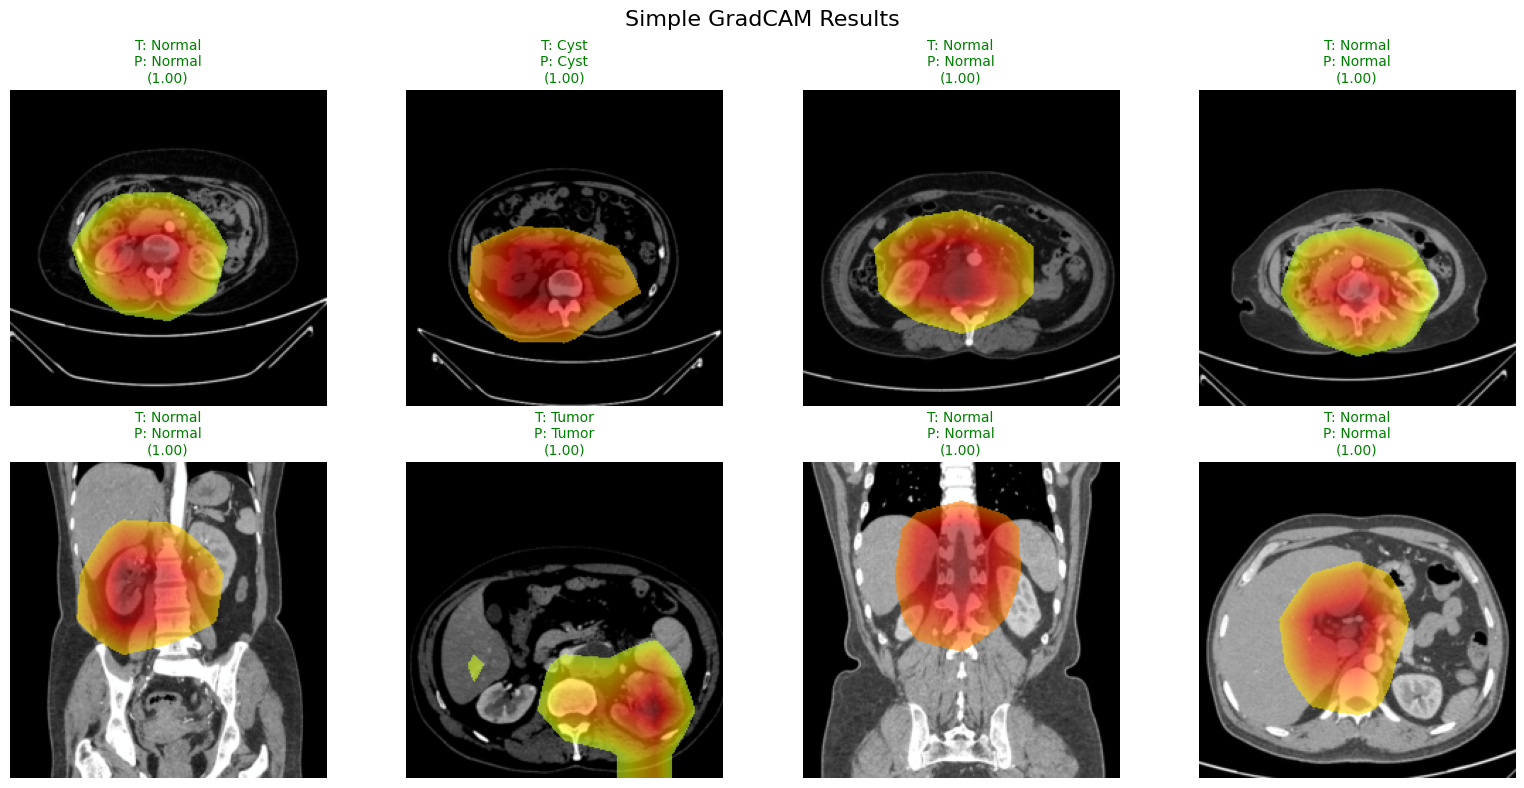

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [20]:
simple_gradcam_demo()

Sample 8 Analysis:
True Label: Cyst
Predicted: Cyst (Confidence: 0.999)
All Probabilities:
  Cyst: 0.999
  Normal: 0.000
  Stone: 0.000
  Tumor: 0.000



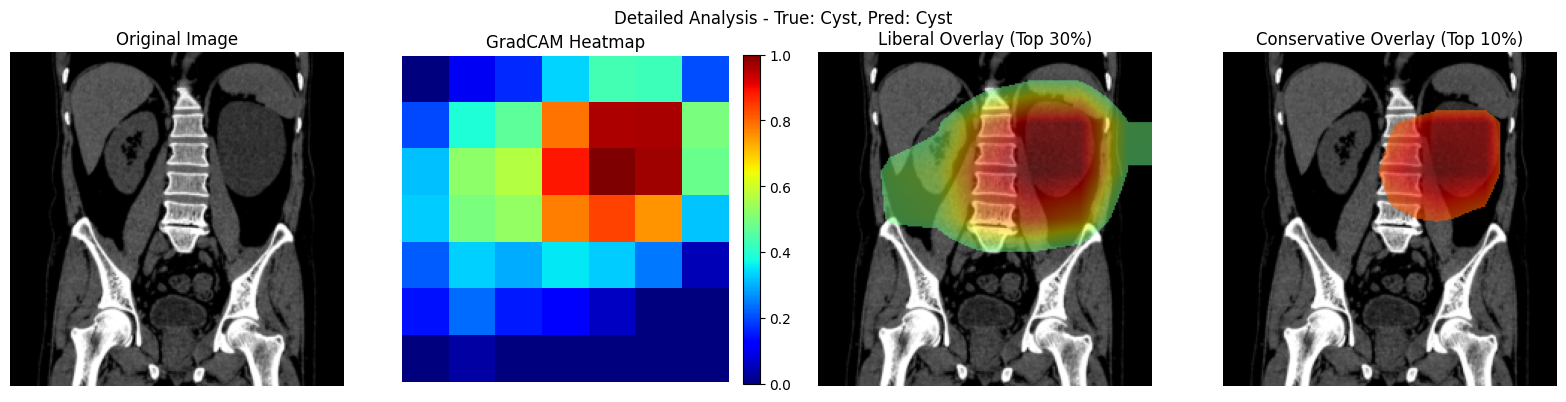

Heatmap Statistics:
  Max activation: 1.000
  Mean activation: 0.352
  Std activation: 0.303
  Area with high activation (>50% max): 24.5%


In [26]:
analyze_single_sample(8)  # Analyze the first sample (index 0)

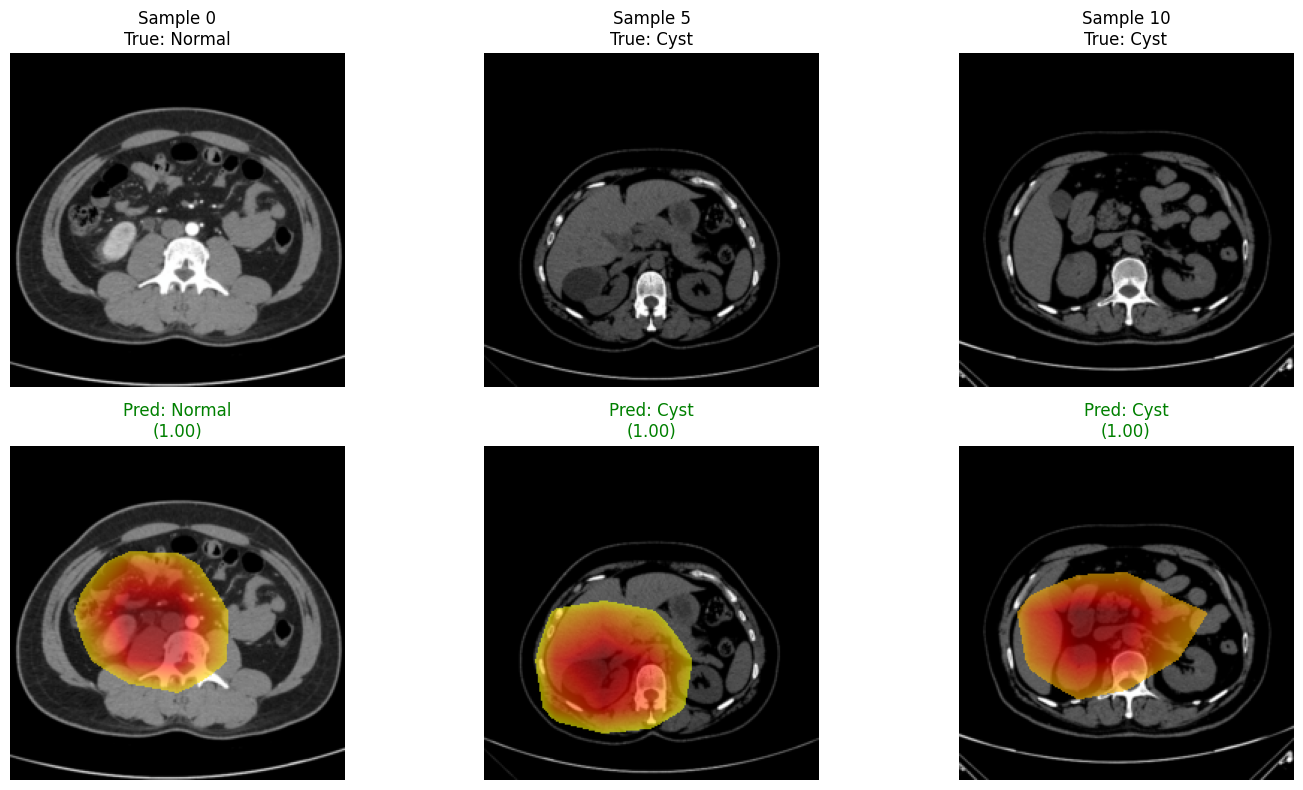

In [22]:
compare_multiple_samples([0,5,10])

In [27]:
# Advanced GradCAM enhancements for better visualizations

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm
from scipy import ndimage
from skimage import segmentation, filters
import random

# 1. HIGHER RESOLUTION GRADCAM
def create_high_res_gradcam():
    """Create GradCAM with higher resolution using earlier layers"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Multi-layer GradCAM
    class MultiLayerGradCAM:
        def __init__(self, model, target_layers):
            self.model = model
            self.target_layers = target_layers
            self.gradients = {}
            self.activations = {}
            self.hooks = []
            
            for name, layer in target_layers.items():
                fh = layer.register_forward_hook(self.make_forward_hook(name))
                bh = layer.register_full_backward_hook(self.make_backward_hook(name))
                self.hooks.extend([fh, bh])
        
        def make_forward_hook(self, name):
            def hook(module, input, output):
                self.activations[name] = output.detach()
            return hook
        
        def make_backward_hook(self, name):
            def hook(module, grad_input, grad_output):
                self.gradients[name] = grad_output[0].detach()
            return hook
        
        def generate(self, input_tensor, class_idx=None, layer_name=None):
            self.gradients.clear()
            self.activations.clear()
            
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            if layer_name is None:
                layer_name = list(self.target_layers.keys())[0]
            
            gradients = self.gradients[layer_name]
            activations = self.activations[layer_name]
            
            weights = gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy(), class_idx
        
        def cleanup(self):
            for hook in self.hooks:
                hook.remove()
    
    # Setup multiple layers for comparison
    target_layers = {
        'layer2': model.layer2[-1].conv2,  # Higher resolution
        'layer3': model.layer3[-1].conv2,  # Medium resolution  
        'layer4': model.layer4[-1].conv2   # Lower resolution
    }
    
    gradcam = MultiLayerGradCAM(model, target_layers)
    
    # Compare resolutions
    sample_idx = 0
    img_tensor, true_label = test_ds[sample_idx]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Original image
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_denorm = img_denorm * STD + MEAN
    img_denorm = np.clip(img_denorm, 0, 1)
    
    axes[0, 0].imshow(img_denorm)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(img_denorm)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    # Generate GradCAM for different layers
    layer_names = ['layer2', 'layer3', 'layer4']
    layer_titles = ['High Res (Layer2)', 'Med Res (Layer3)', 'Low Res (Layer4)']
    
    for i, (layer_name, title) in enumerate(zip(layer_names, layer_titles)):
        heatmap, pred_class = gradcam.generate(
            img_tensor.unsqueeze(0).to(device), 
            layer_name=layer_name
        )
        
        # Raw heatmap
        axes[0, i+1].imshow(heatmap, cmap='jet')
        axes[0, i+1].set_title(f'{title}\nRaw Heatmap')
        axes[0, i+1].axis('off')
        
        # Overlay
        H, W = img_denorm.shape[:2]
        heatmap_resized = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
        threshold = np.percentile(heatmap_resized, 85)
        mask = heatmap_resized >= threshold
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        overlay = img_denorm.copy()
        mask_3d = np.stack([mask, mask, mask], axis=2)
        overlay = (1 - 0.6 * mask_3d) * overlay + 0.6 * mask_3d * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        
        axes[1, i+1].imshow(overlay)
        axes[1, i+1].set_title(f'{title}\nOverlay')
        axes[1, i+1].axis('off')
    
    plt.suptitle(f'Multi-Resolution GradCAM Comparison\nTrue: {class_names[true_label]}, Pred: {class_names[pred_class]}')
    plt.tight_layout()
    plt.show()
    
    gradcam.cleanup()
    
    return model, class_names

# 2. GUIDED GRADCAM (COMBINES GRADCAM + GUIDED BACKPROP)
def create_guided_gradcam():
    """Create Guided GradCAM for sharper visualizations"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Guided Backpropagation
    class GuidedBackprop:
        def __init__(self, model):
            self.model = model
            self.hooks = []
            self.update_relus()
        
        def update_relus(self):
            def relu_hook_function(module, grad_in, grad_out):
                # Only keep positive gradients
                return (torch.clamp(grad_in[0], min=0.0),)
            
            for module in self.model.modules():
                if isinstance(module, nn.ReLU):
                    hook = module.register_backward_hook(relu_hook_function)
                    self.hooks.append(hook)
        
        def generate(self, input_tensor, class_idx=None):
            input_tensor.requires_grad_()
            
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            gradient = input_tensor.grad.data[0]
            return gradient.cpu().numpy()
        
        def cleanup(self):
            for hook in self.hooks:
                hook.remove()
    
    # Regular GradCAM
    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy(), class_idx
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    # Initialize both methods
    gradcam = SimpleGradCAM(model, model.layer4[-1].conv2)
    guided_bp = GuidedBackprop(model)
    
    # Test on a sample
    sample_idx = 0
    img_tensor, true_label = test_ds[sample_idx]
    
    # Generate visualizations
    gradcam_heatmap, pred_class = gradcam.generate(img_tensor.unsqueeze(0).to(device))
    guided_gradients = guided_bp.generate(img_tensor.unsqueeze(0).to(device), pred_class)
    
    # Combine GradCAM and Guided Backprop
    H, W = img_tensor.shape[1:]
    gradcam_resized = cv2.resize(gradcam_heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
    
    # Guided GradCAM = GradCAM * Guided Backprop
    guided_gradcam = guided_gradients * gradcam_resized[None, :, :]
    guided_gradcam = np.maximum(guided_gradcam, 0)  # ReLU
    
    # Normalize
    for i in range(3):
        guided_gradcam[i] = guided_gradcam[i] / (np.max(guided_gradcam[i]) + 1e-8)
    
    # Denormalize original image
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_denorm = img_denorm * STD + MEAN
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Top row: Original, GradCAM, Guided Backprop
    axes[0, 0].imshow(img_denorm)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gradcam_heatmap, cmap='jet')
    axes[0, 1].set_title('GradCAM')
    axes[0, 1].axis('off')
    
    # Guided backprop (grayscale)
    guided_gray = np.mean(np.abs(guided_gradients), axis=0)
    guided_gray = guided_gray / (np.max(guided_gray) + 1e-8)
    axes[0, 2].imshow(guided_gray, cmap='gray')
    axes[0, 2].set_title('Guided Backprop')
    axes[0, 2].axis('off')
    
    # Bottom row: Overlays
    # GradCAM overlay
    gradcam_resized_full = cv2.resize(gradcam_heatmap, (img_denorm.shape[1], img_denorm.shape[0]))
    threshold = np.percentile(gradcam_resized_full, 85)
    mask = gradcam_resized_full >= threshold
    heatmap_colored = plt.cm.jet(gradcam_resized_full)[:, :, :3]
    overlay_gradcam = img_denorm.copy()
    mask_3d = np.stack([mask, mask, mask], axis=2)
    overlay_gradcam = (1 - 0.6 * mask_3d) * overlay_gradcam + 0.6 * mask_3d * heatmap_colored
    overlay_gradcam = np.clip(overlay_gradcam, 0, 1)
    
    axes[1, 0].imshow(overlay_gradcam)
    axes[1, 0].set_title('GradCAM Overlay')
    axes[1, 0].axis('off')
    
    # Guided GradCAM
    guided_gradcam_vis = np.transpose(guided_gradcam, (1, 2, 0))
    guided_gradcam_vis = np.clip(guided_gradcam_vis, 0, 1)
    axes[1, 1].imshow(guided_gradcam_vis)
    axes[1, 1].set_title('Guided GradCAM')
    axes[1, 1].axis('off')
    
    # Combined overlay
    guided_gradcam_gray = np.mean(guided_gradcam_vis, axis=2)
    threshold_guided = np.percentile(guided_gradcam_gray, 95)
    mask_guided = guided_gradcam_gray >= threshold_guided
    overlay_guided = img_denorm.copy()
    mask_guided_3d = np.stack([mask_guided, mask_guided, mask_guided], axis=2)
    heatmap_guided_colored = plt.cm.hot(guided_gradcam_gray)[:, :, :3]
    overlay_guided = (1 - 0.7 * mask_guided_3d) * overlay_guided + 0.7 * mask_guided_3d * heatmap_guided_colored
    overlay_guided = np.clip(overlay_guided, 0, 1)
    
    axes[1, 2].imshow(overlay_guided)
    axes[1, 2].set_title('Guided GradCAM Overlay')
    axes[1, 2].axis('off')
    
    plt.suptitle(f'Guided GradCAM Comparison\nTrue: {class_names[true_label]}, Pred: {class_names[pred_class]}')
    plt.tight_layout()
    plt.show()
    
    gradcam.cleanup()
    guided_bp.cleanup()
    
    return model, class_names

# 3. SMOOTH GRADCAM (REDUCES NOISE)
def create_smooth_gradcam(n_samples=50, noise_level=0.1):
    """Create SmoothGrad version of GradCAM for noise reduction"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    class SmoothGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None, n_samples=50, noise_level=0.1):
            if class_idx is None:
                with torch.no_grad():
                    output = self.model(input_tensor)
                    class_idx = output.argmax(dim=1).item()
            
            # Generate multiple noisy versions
            smooth_cam = 0
            
            for _ in range(n_samples):
                # Add noise
                noise = torch.randn_like(input_tensor) * noise_level
                noisy_input = input_tensor + noise
                
                self.gradients = None
                self.activations = None
                
                output = self.model(noisy_input)
                self.model.zero_grad()
                output[0, class_idx].backward()
                
                weights = self.gradients.mean(dim=(2, 3), keepdim=True)
                cam = (weights * self.activations).sum(dim=1).squeeze(0)
                cam = F.relu(cam)
                
                smooth_cam += cam.cpu().numpy()
            
            # Average and normalize
            smooth_cam /= n_samples
            smooth_cam = smooth_cam / (smooth_cam.max() + 1e-8)
            
            return smooth_cam, class_idx
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    # Compare regular vs smooth GradCAM
    smooth_gradcam = SmoothGradCAM(model, model.layer4[-1].conv2)
    
    class RegularGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy(), class_idx
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    regular_gradcam = RegularGradCAM(model, model.layer4[-1].conv2)
    
    # Test on sample
    sample_idx = 0
    img_tensor, true_label = test_ds[sample_idx]
    
    # Generate both versions
    print("Generating regular GradCAM...")
    regular_cam, pred_class = regular_gradcam.generate(img_tensor.unsqueeze(0).to(device))
    
    print("Generating smooth GradCAM (this may take a moment)...")
    smooth_cam, _ = smooth_gradcam.generate(
        img_tensor.unsqueeze(0).to(device), 
        class_idx=pred_class,
        n_samples=n_samples,
        noise_level=noise_level
    )
    
    # Denormalize image
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_denorm = img_denorm * STD + MEAN
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Create comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(img_denorm)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Regular GradCAM
    axes[0, 1].imshow(regular_cam, cmap='jet')
    axes[0, 1].set_title('Regular GradCAM')
    axes[0, 1].axis('off')
    
    # Smooth GradCAM
    axes[0, 2].imshow(smooth_cam, cmap='jet')
    axes[0, 2].set_title(f'Smooth GradCAM\n(n={n_samples}, noise={noise_level})')
    axes[0, 2].axis('off')
    
    # Overlays
    def create_overlay(img, heatmap, title, ax):
        H, W = img.shape[:2]
        heatmap_resized = cv2.resize(heatmap, (W, H))
        threshold = np.percentile(heatmap_resized, 85)
        mask = heatmap_resized >= threshold
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        overlay = img.copy()
        mask_3d = np.stack([mask, mask, mask], axis=2)
        overlay = (1 - 0.6 * mask_3d) * overlay + 0.6 * mask_3d * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        ax.imshow(overlay)
        ax.set_title(title)
        ax.axis('off')
    
    create_overlay(img_denorm, img_denorm, 'Original', axes[1, 0])
    create_overlay(img_denorm, regular_cam, 'Regular Overlay', axes[1, 1])
    create_overlay(img_denorm, smooth_cam, 'Smooth Overlay', axes[1, 2])
    
    plt.suptitle(f'Smooth GradCAM Comparison\nTrue: {class_names[true_label]}, Pred: {class_names[pred_class]}')
    plt.tight_layout()
    plt.show()
    
    regular_gradcam.cleanup()
    smooth_gradcam.cleanup()
    
    # Print statistics
    print("\nGradCAM Statistics:")
    print(f"Regular - Max: {regular_cam.max():.3f}, Mean: {regular_cam.mean():.3f}, Std: {regular_cam.std():.3f}")
    print(f"Smooth  - Max: {smooth_cam.max():.3f}, Mean: {smooth_cam.mean():.3f}, Std: {smooth_cam.std():.3f}")
    
    return model, class_names

# Quick runners
print("🚀 Advanced GradCAM Enhancements Available:")
print("1. create_high_res_gradcam() - Compare different layer resolutions")
print("2. create_guided_gradcam() - Sharper, more detailed visualizations") 
print("3. create_smooth_gradcam() - Smoother, less noisy results")
print("\n" + "="*60)
print("Try: create_high_res_gradcam()")
print("="*60)

🚀 Advanced GradCAM Enhancements Available:
1. create_high_res_gradcam() - Compare different layer resolutions
2. create_guided_gradcam() - Sharper, more detailed visualizations
3. create_smooth_gradcam() - Smoother, less noisy results

Try: create_high_res_gradcam()


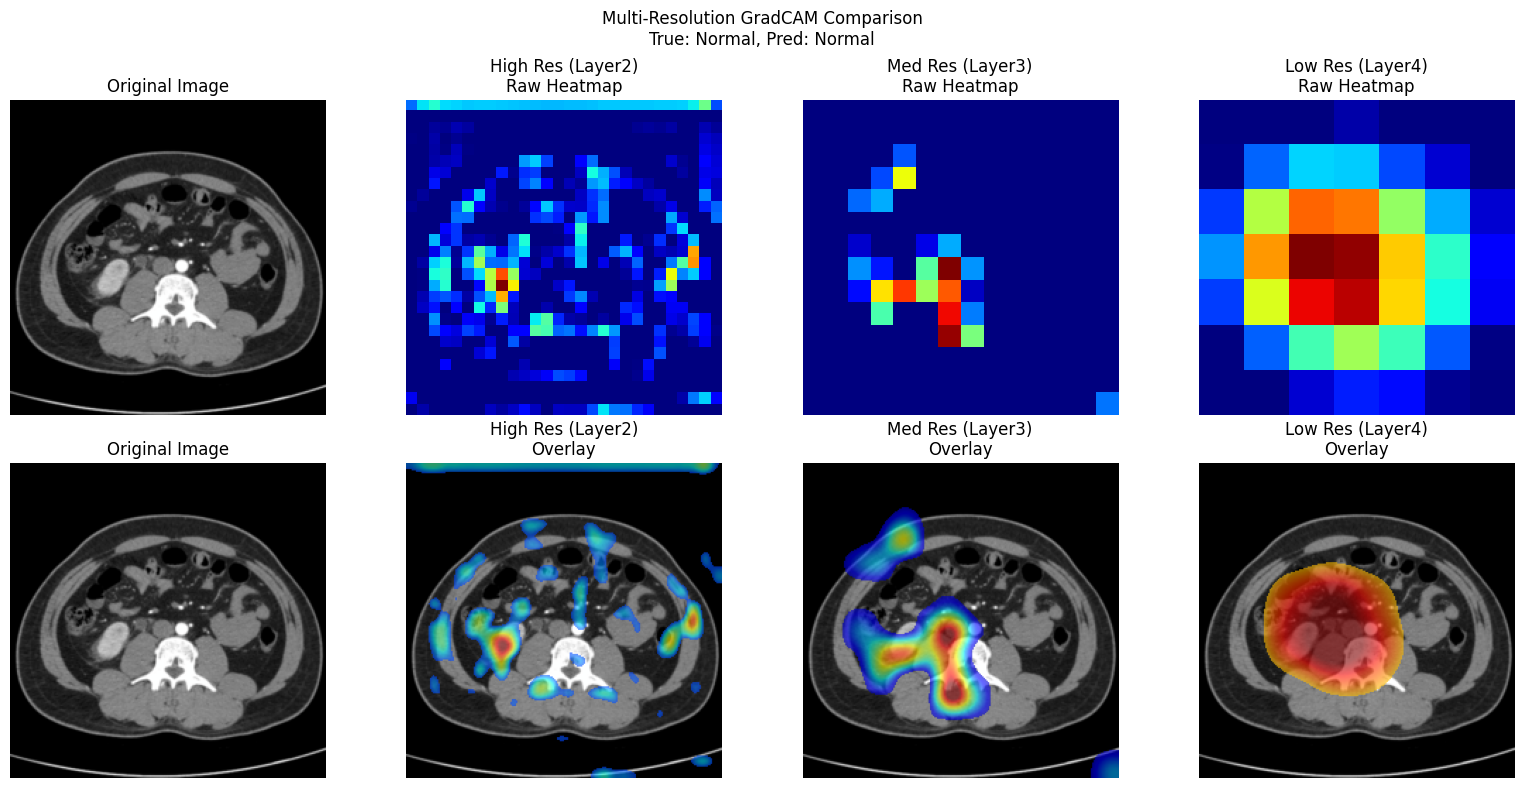

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [28]:
create_high_res_gradcam()

In [29]:
# Optimal GradCAM fusion and analysis based on your multi-resolution results

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as mpl_cm
from scipy import ndimage
import random

def create_optimal_fusion_gradcam():
    """Create fused GradCAM that combines the best aspects of different layers"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    class FusedGradCAM:
        def __init__(self, model, target_layers):
            self.model = model
            self.target_layers = target_layers
            self.gradients = {}
            self.activations = {}
            self.hooks = []
            
            for name, layer in target_layers.items():
                fh = layer.register_forward_hook(self.make_forward_hook(name))
                bh = layer.register_full_backward_hook(self.make_backward_hook(name))
                self.hooks.extend([fh, bh])
        
        def make_forward_hook(self, name):
            def hook(module, input, output):
                self.activations[name] = output.detach()
            return hook
        
        def make_backward_hook(self, name):
            def hook(module, grad_input, grad_output):
                self.gradients[name] = grad_output[0].detach()
            return hook
        
        def generate_layer_cam(self, input_tensor, layer_name, class_idx):
            """Generate GradCAM for a specific layer"""
            gradients = self.gradients[layer_name]
            activations = self.activations[layer_name]
            
            weights = gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy()
        
        def generate_fused(self, input_tensor, class_idx=None, fusion_weights=None):
            """Generate fused GradCAM from multiple layers"""
            
            # Clear previous data
            self.gradients.clear()
            self.activations.clear()
            
            # Forward pass
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            # Backward pass
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            # Default fusion weights (based on your results)
            if fusion_weights is None:
                fusion_weights = {
                    'layer2': 0.2,  # High detail but noisy
                    'layer3': 0.3,  # Good balance
                    'layer4': 0.5   # Clean and interpretable
                }
            
            # Get target image size
            target_size = (224, 224)  # Standard input size
            
            # Generate CAM for each layer and resize to common size
            layer_cams = {}
            for layer_name in self.target_layers.keys():
                cam = self.generate_layer_cam(input_tensor, layer_name, class_idx)
                # Resize to common size
                cam_resized = cv2.resize(cam, target_size, interpolation=cv2.INTER_CUBIC)
                layer_cams[layer_name] = cam_resized
            
            # Fuse the CAMs
            fused_cam = np.zeros(target_size)
            total_weight = 0
            
            for layer_name, weight in fusion_weights.items():
                if layer_name in layer_cams:
                    fused_cam += weight * layer_cams[layer_name]
                    total_weight += weight
            
            # Normalize
            fused_cam /= total_weight
            fused_cam = fused_cam / (fused_cam.max() + 1e-8)
            
            return fused_cam, layer_cams, class_idx
        
        def cleanup(self):
            for hook in self.hooks:
                hook.remove()
    
    # Setup multi-layer GradCAM
    target_layers = {
        'layer2': model.layer2[-1].conv2,
        'layer3': model.layer3[-1].conv2,
        'layer4': model.layer4[-1].conv2
    }
    
    fused_gradcam = FusedGradCAM(model, target_layers)
    
    # Test on multiple samples
    sample_indices = [0, 5, 10, 15]
    
    for sample_idx in sample_indices:
        img_tensor, true_label = test_ds[sample_idx]
        
        # Get prediction
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_label = logits.argmax(dim=1).item()
            confidence = F.softmax(logits, dim=1).max().item()
        
        # Generate fused GradCAM
        fused_cam, layer_cams, pred_class = fused_gradcam.generate_fused(
            img_tensor.unsqueeze(0).to(device)
        )
        
        # Denormalize image
        MEAN = np.array([0.485, 0.456, 0.406])
        STD = np.array([0.229, 0.224, 0.225])
        img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_denorm = img_denorm * STD + MEAN
        img_denorm = np.clip(img_denorm, 0, 1)
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        
        # Row 1: Original and individual layers
        axes[0, 0].imshow(img_denorm)
        axes[0, 0].set_title(f'Original\nTrue: {class_names[true_label]}', fontweight='bold')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(layer_cams['layer3'], cmap='jet')
        axes[0, 1].set_title('Layer 3 (Med Res)', fontweight='bold')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(layer_cams['layer4'], cmap='jet')
        axes[0, 2].set_title('Layer 4 (Low Res)', fontweight='bold')
        axes[0, 2].axis('off')
        
        # Row 2: Fused CAM and overlays
        axes[1, 0].imshow(fused_cam, cmap='jet')
        axes[1, 0].set_title('Fused GradCAM\n(Weighted Combination)', fontweight='bold')
        axes[1, 0].axis('off')
        
        # Create overlay function
        def create_smart_overlay(img, heatmap, threshold_percentile=85, alpha=0.6):
            H, W = img.shape[:2]
            heatmap_resized = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
            
            # Adaptive thresholding based on heatmap distribution
            if np.std(heatmap_resized) > 0.1:  # High variation
                threshold = np.percentile(heatmap_resized, 90)
            else:  # Low variation
                threshold = np.percentile(heatmap_resized, 80)
            
            mask = heatmap_resized >= threshold
            
            # Use different colormap for better contrast
            heatmap_colored = plt.cm.hot(heatmap_resized)[:, :, :3]
            
            overlay = img.copy()
            mask_3d = np.stack([mask, mask, mask], axis=2)
            overlay = (1 - alpha * mask_3d) * overlay + alpha * mask_3d * heatmap_colored
            
            return np.clip(overlay, 0, 1), mask
        
        # Layer 3 overlay
        overlay_l3, mask_l3 = create_smart_overlay(img_denorm, layer_cams['layer3'])
        axes[1, 1].imshow(overlay_l3)
        axes[1, 1].set_title('Layer 3 Overlay', fontweight='bold')
        axes[1, 1].axis('off')
        
        # Fused overlay
        overlay_fused, mask_fused = create_smart_overlay(img_denorm, fused_cam)
        axes[1, 2].imshow(overlay_fused)
        color = 'green' if pred_label == true_label else 'red'
        axes[1, 2].set_title(f'Fused Overlay\nPred: {class_names[pred_label]} ({confidence:.2f})', 
                           fontweight='bold', color=color)
        axes[1, 2].axis('off')
        
        # Row 3: Analysis and statistics
        # Attention coverage analysis
        coverage_l3 = mask_l3.mean() * 100
        coverage_fused = mask_fused.mean() * 100
        
        # Create attention statistics plot
        layers = ['Layer 2', 'Layer 3', 'Layer 4', 'Fused']
        max_activations = [layer_cams['layer2'].max(), layer_cams['layer3'].max(), 
                          layer_cams['layer4'].max(), fused_cam.max()]
        mean_activations = [layer_cams['layer2'].mean(), layer_cams['layer3'].mean(), 
                           layer_cams['layer4'].mean(), fused_cam.mean()]
        
        axes[2, 0].bar(layers, max_activations, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'red'])
        axes[2, 0].set_title('Max Activation by Layer')
        axes[2, 0].set_ylabel('Max Activation')
        axes[2, 0].tick_params(axis='x', rotation=45)
        
        # Attention focus heatmap
        axes[2, 1].imshow(fused_cam, cmap='hot', interpolation='bilinear')
        axes[2, 1].set_title('Fused Attention (Smoothed)')
        axes[2, 1].axis('off')
        
        # Contour overlay
        axes[2, 2].imshow(img_denorm, alpha=0.8)
        contours = axes[2, 2].contour(fused_cam, levels=5, colors='yellow', linewidths=2, alpha=0.8)
        axes[2, 2].clabel(contours, inline=True, fontsize=8)
        axes[2, 2].set_title('Attention Contours')
        axes[2, 2].axis('off')
        
        plt.suptitle(f'Sample {sample_idx}: Optimal Fused GradCAM Analysis\n'
                    f'True: {class_names[true_label]} | Pred: {class_names[pred_label]} | '
                    f'Confidence: {confidence:.3f}', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print(f"\nSample {sample_idx} - Detailed Analysis:")
        print(f"  True Label: {class_names[true_label]}")
        print(f"  Prediction: {class_names[pred_label]} (Confidence: {confidence:.3f})")
        print(f"  Layer 2 Stats: Max={layer_cams['layer2'].max():.3f}, Mean={layer_cams['layer2'].mean():.3f}")
        print(f"  Layer 3 Stats: Max={layer_cams['layer3'].max():.3f}, Mean={layer_cams['layer3'].mean():.3f}")
        print(f"  Layer 4 Stats: Max={layer_cams['layer4'].max():.3f}, Mean={layer_cams['layer4'].mean():.3f}")
        print(f"  Fused Stats:   Max={fused_cam.max():.3f}, Mean={fused_cam.mean():.3f}")
        print(f"  Attention Coverage: Layer3={coverage_l3:.1f}%, Fused={coverage_fused:.1f}%")
        print("-" * 60)
    
    fused_gradcam.cleanup()
    return model, class_names

def create_class_comparison_gradcam():
    """Compare GradCAM patterns across different kidney conditions"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    from torchvision.models import resnet18
    import torch.nn as nn
    
    model = resnet18(weights=None)
    num_classes = len(clean_df["target"].unique())
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load("resnet18_kidney_best.pth", map_location=device, weights_only=True))
    model = model.to(device)
    model.eval()
    
    class_names = sorted(clean_df["Class"].unique())
    
    # Simple GradCAM for comparison
    class SimpleGradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.activations = None
            self.forward_hook = target_layer.register_forward_hook(self.save_activation)
            self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)
        
        def save_activation(self, module, input, output):
            self.activations = output.detach()
        
        def save_gradient(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        def generate(self, input_tensor, class_idx=None):
            self.gradients = None
            self.activations = None
            
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = output.argmax(dim=1).item()
            
            self.model.zero_grad()
            output[0, class_idx].backward()
            
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
            cam = (weights * self.activations).sum(dim=1).squeeze(0)
            cam = F.relu(cam)
            cam = cam / (cam.max() + 1e-8)
            
            return cam.cpu().numpy(), class_idx
        
        def cleanup(self):
            self.forward_hook.remove()
            self.backward_hook.remove()
    
    # Use Layer 3 as optimal balance (based on your results)
    gradcam = SimpleGradCAM(model, model.layer3[-1].conv2)
    
    # Find representative samples for each class
    class_samples = {}
    for i, (img_tensor, true_label) in enumerate(test_ds):
        class_name = class_names[true_label]
        if class_name not in class_samples:
            # Check if model predicts correctly
            with torch.no_grad():
                logits = model(img_tensor.unsqueeze(0).to(device))
                pred_label = logits.argmax(dim=1).item()
                confidence = F.softmax(logits, dim=1).max().item()
            
            if pred_label == true_label and confidence > 0.9:  # High confidence correct predictions
                class_samples[class_name] = {
                    'idx': i,
                    'tensor': img_tensor,
                    'label': true_label,
                    'confidence': confidence
                }
        
        if len(class_samples) == len(class_names):
            break
    
    # Create class comparison
    n_classes = len(class_samples)
    fig, axes = plt.subplots(3, n_classes, figsize=(5*n_classes, 15))
    
    if n_classes == 1:
        axes = axes.reshape(3, 1)
    
    MEAN = np.array([0.485, 0.456, 0.406])
    STD = np.array([0.229, 0.224, 0.225])
    
    class_stats = {}
    
    for i, (class_name, sample_info) in enumerate(class_samples.items()):
        img_tensor = sample_info['tensor']
        confidence = sample_info['confidence']
        
        # Generate GradCAM
        heatmap, _ = gradcam.generate(img_tensor.unsqueeze(0).to(device))
        
        # Denormalize image
        img_denorm = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_denorm = img_denorm * STD + MEAN
        img_denorm = np.clip(img_denorm, 0, 1)
        
        # Create overlay
        H, W = img_denorm.shape[:2]
        heatmap_resized = cv2.resize(heatmap, (W, H), interpolation=cv2.INTER_CUBIC)
        threshold = np.percentile(heatmap_resized, 85)
        mask = heatmap_resized >= threshold
        heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
        overlay = img_denorm.copy()
        mask_3d = np.stack([mask, mask, mask], axis=2)
        overlay = (1 - 0.6 * mask_3d) * overlay + 0.6 * mask_3d * heatmap_colored
        overlay = np.clip(overlay, 0, 1)
        
        # Plot
        # Original
        axes[0, i].imshow(img_denorm)
        axes[0, i].set_title(f'{class_name}\nConfidence: {confidence:.2f}', fontweight='bold')
        axes[0, i].axis('off')
        
        # Heatmap
        im = axes[1, i].imshow(heatmap, cmap='jet')
        axes[1, i].set_title('Attention Heatmap', fontweight='bold')
        axes[1, i].axis('off')
        
        # Overlay
        axes[2, i].imshow(overlay)
        axes[2, i].set_title('Overlay', fontweight='bold')
        axes[2, i].axis('off')
        
        # Store statistics
        class_stats[class_name] = {
            'max_activation': heatmap.max(),
            'mean_activation': heatmap.mean(),
            'std_activation': heatmap.std(),
            'coverage': mask.mean(),
            'focus_score': (heatmap > 0.5 * heatmap.max()).sum() / heatmap.size
        }
    
    plt.suptitle('Class-Specific Attention Patterns (Layer 3 - Optimal Resolution)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print comparative statistics
    print("\n" + "="*60)
    print("CLASS-SPECIFIC ATTENTION ANALYSIS")
    print("="*60)
    
    for class_name, stats in class_stats.items():
        print(f"\n{class_name}:")
        print(f"  Max Activation:  {stats['max_activation']:.3f}")
        print(f"  Mean Activation: {stats['mean_activation']:.3f}")
        print(f"  Std Activation:  {stats['std_activation']:.3f}")
        print(f"  Coverage:        {stats['coverage']:.1%}")
        print(f"  Focus Score:     {stats['focus_score']:.3f}")
    
    gradcam.cleanup()
    return model, class_names, class_stats

# Quick runners
print("🎯 Optimal GradCAM Analysis Tools:")
print("1. create_optimal_fusion_gradcam() - Best fusion of all layers")
print("2. create_class_comparison_gradcam() - Compare attention across diseases")
print("\n" + "="*60)
print("RECOMMENDED: create_optimal_fusion_gradcam()")
print("="*60)

🎯 Optimal GradCAM Analysis Tools:
1. create_optimal_fusion_gradcam() - Best fusion of all layers
2. create_class_comparison_gradcam() - Compare attention across diseases

RECOMMENDED: create_optimal_fusion_gradcam()


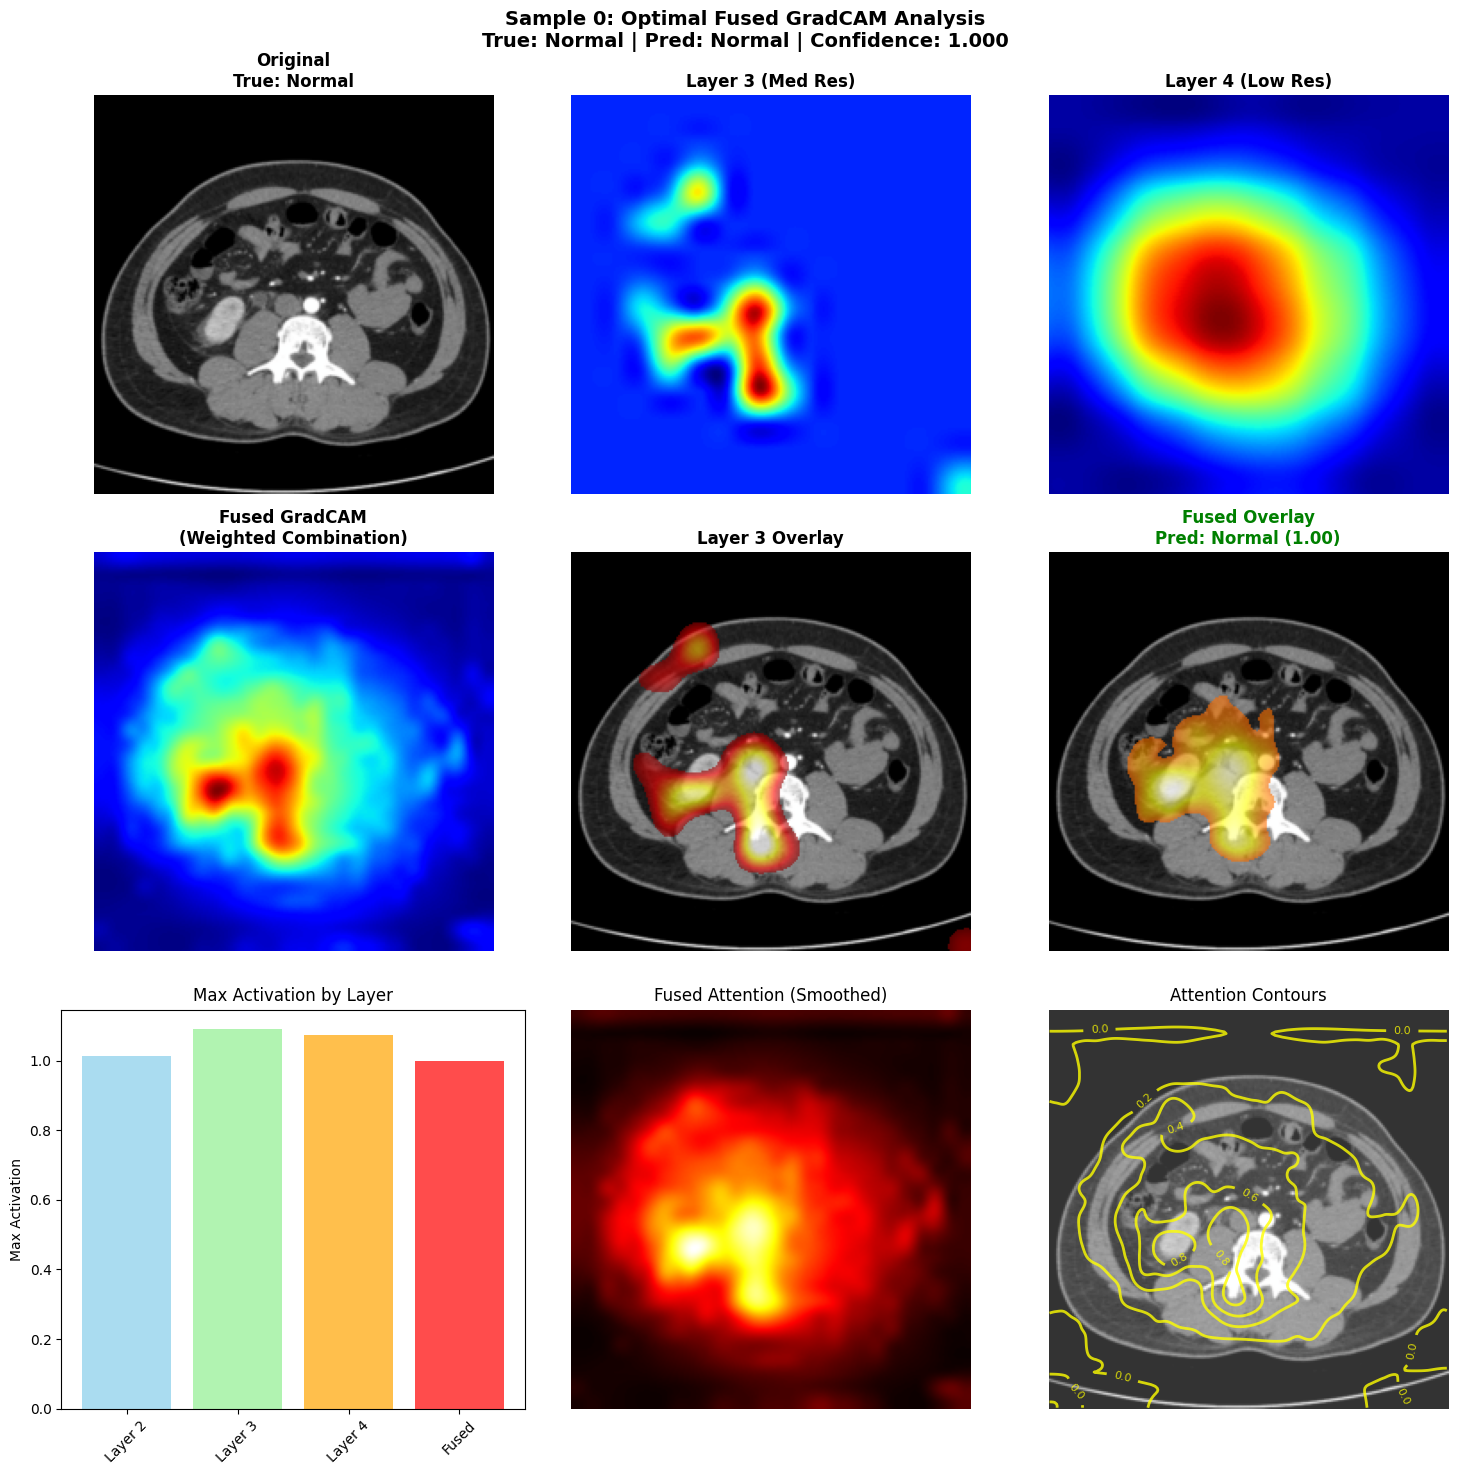


Sample 0 - Detailed Analysis:
  True Label: Normal
  Prediction: Normal (Confidence: 1.000)
  Layer 2 Stats: Max=1.013, Mean=0.077
  Layer 3 Stats: Max=1.092, Mean=0.054
  Layer 4 Stats: Max=1.073, Mean=0.302
  Fused Stats:   Max=1.000, Mean=0.202
  Attention Coverage: Layer3=10.0%, Fused=10.0%
------------------------------------------------------------


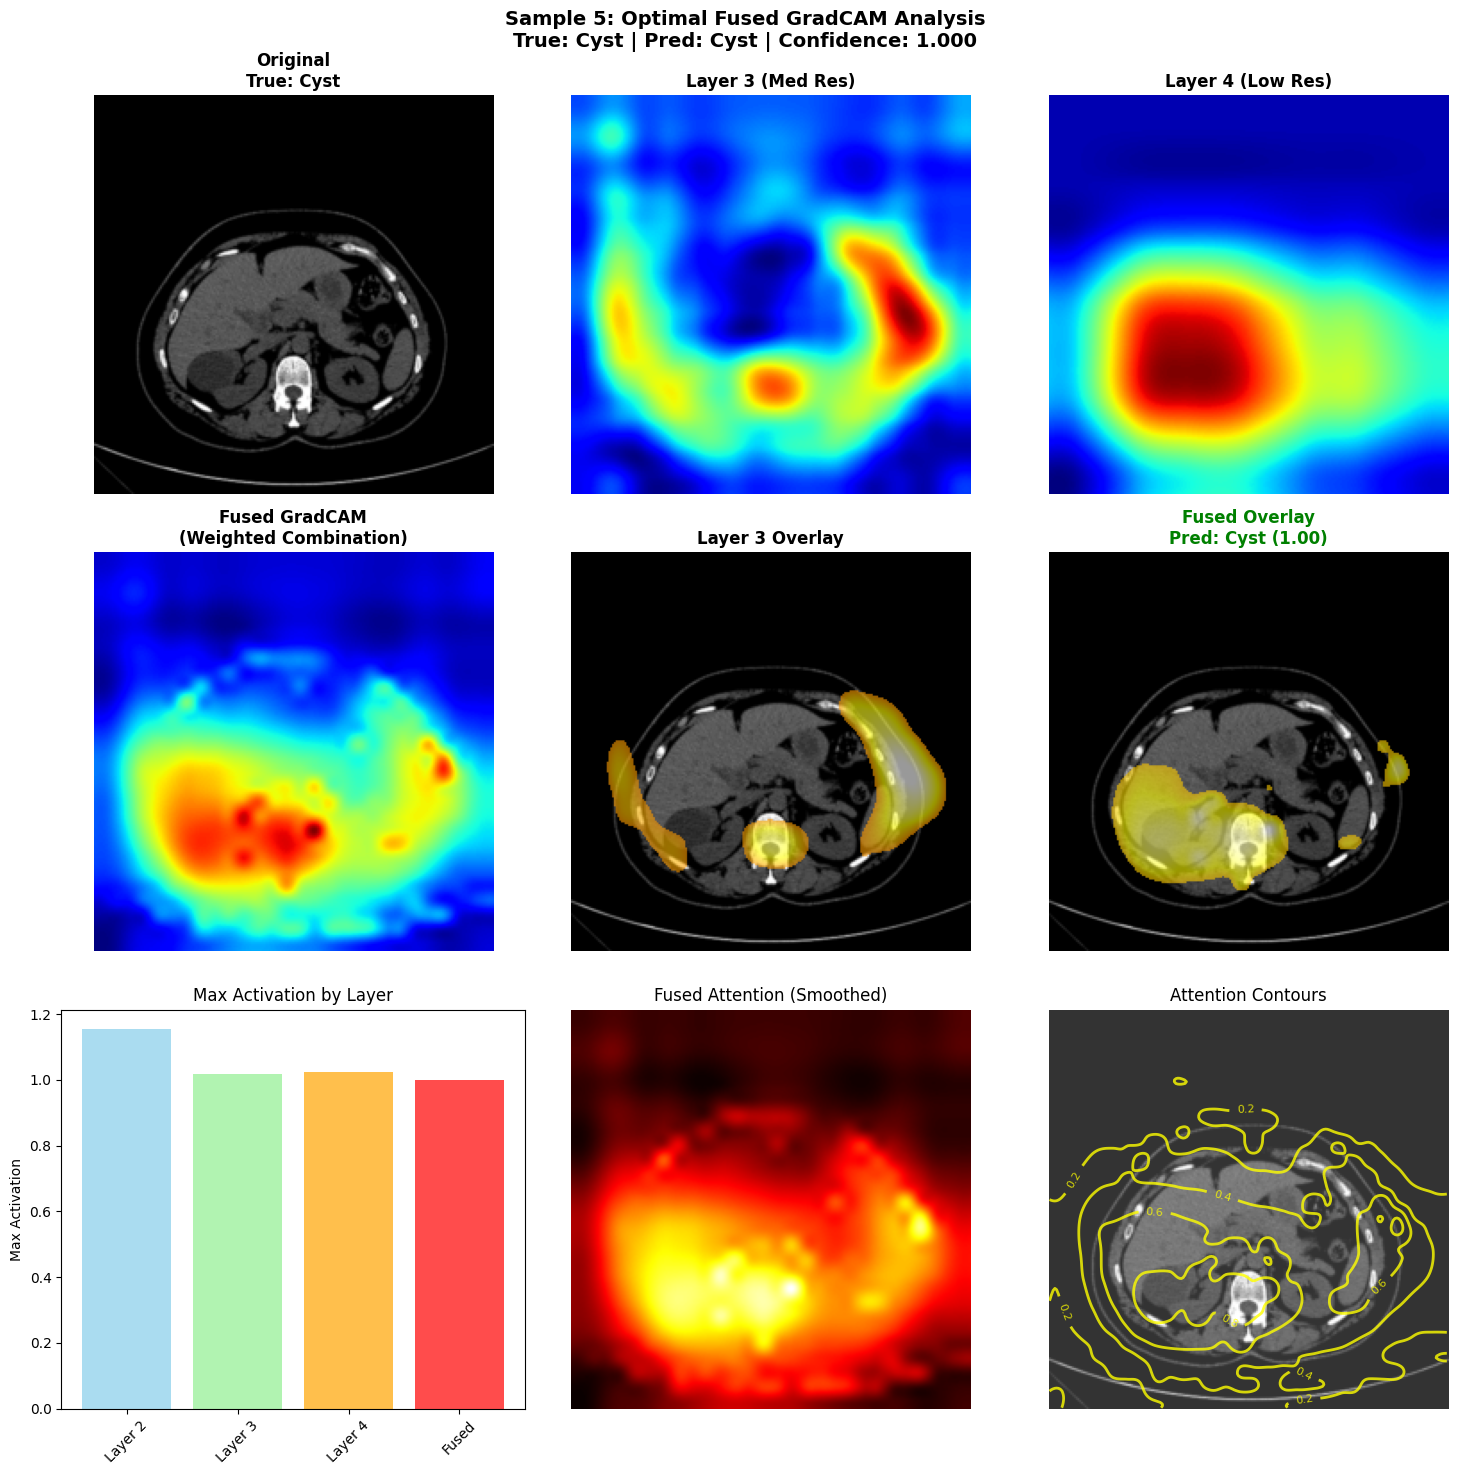


Sample 5 - Detailed Analysis:
  True Label: Cyst
  Prediction: Cyst (Confidence: 1.000)
  Layer 2 Stats: Max=1.157, Mean=0.044
  Layer 3 Stats: Max=1.019, Mean=0.281
  Layer 4 Stats: Max=1.023, Mean=0.304
  Fused Stats:   Max=1.000, Mean=0.312
  Attention Coverage: Layer3=10.0%, Fused=10.0%
------------------------------------------------------------


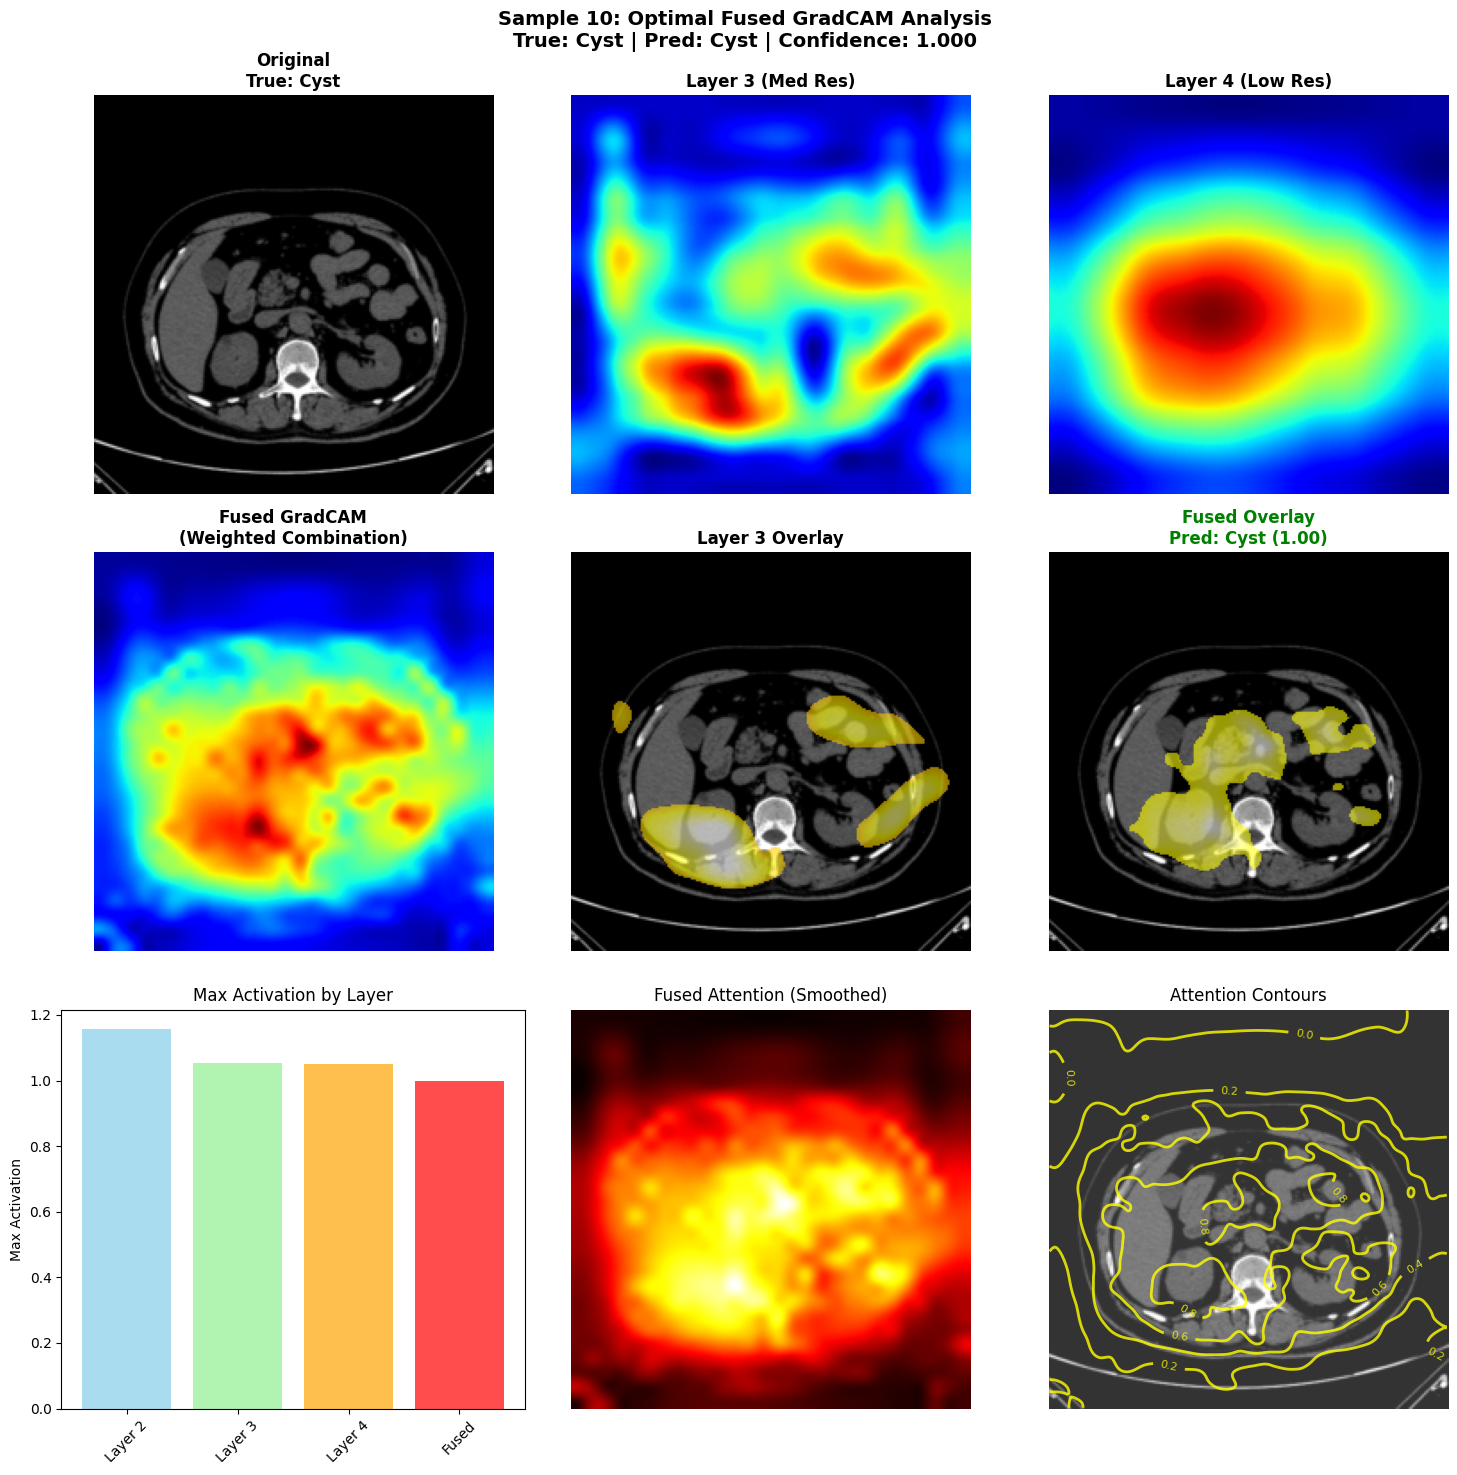


Sample 10 - Detailed Analysis:
  True Label: Cyst
  Prediction: Cyst (Confidence: 1.000)
  Layer 2 Stats: Max=1.158, Mean=0.086
  Layer 3 Stats: Max=1.055, Mean=0.297
  Layer 4 Stats: Max=1.051, Mean=0.366
  Fused Stats:   Max=1.000, Mean=0.349
  Attention Coverage: Layer3=10.0%, Fused=10.0%
------------------------------------------------------------


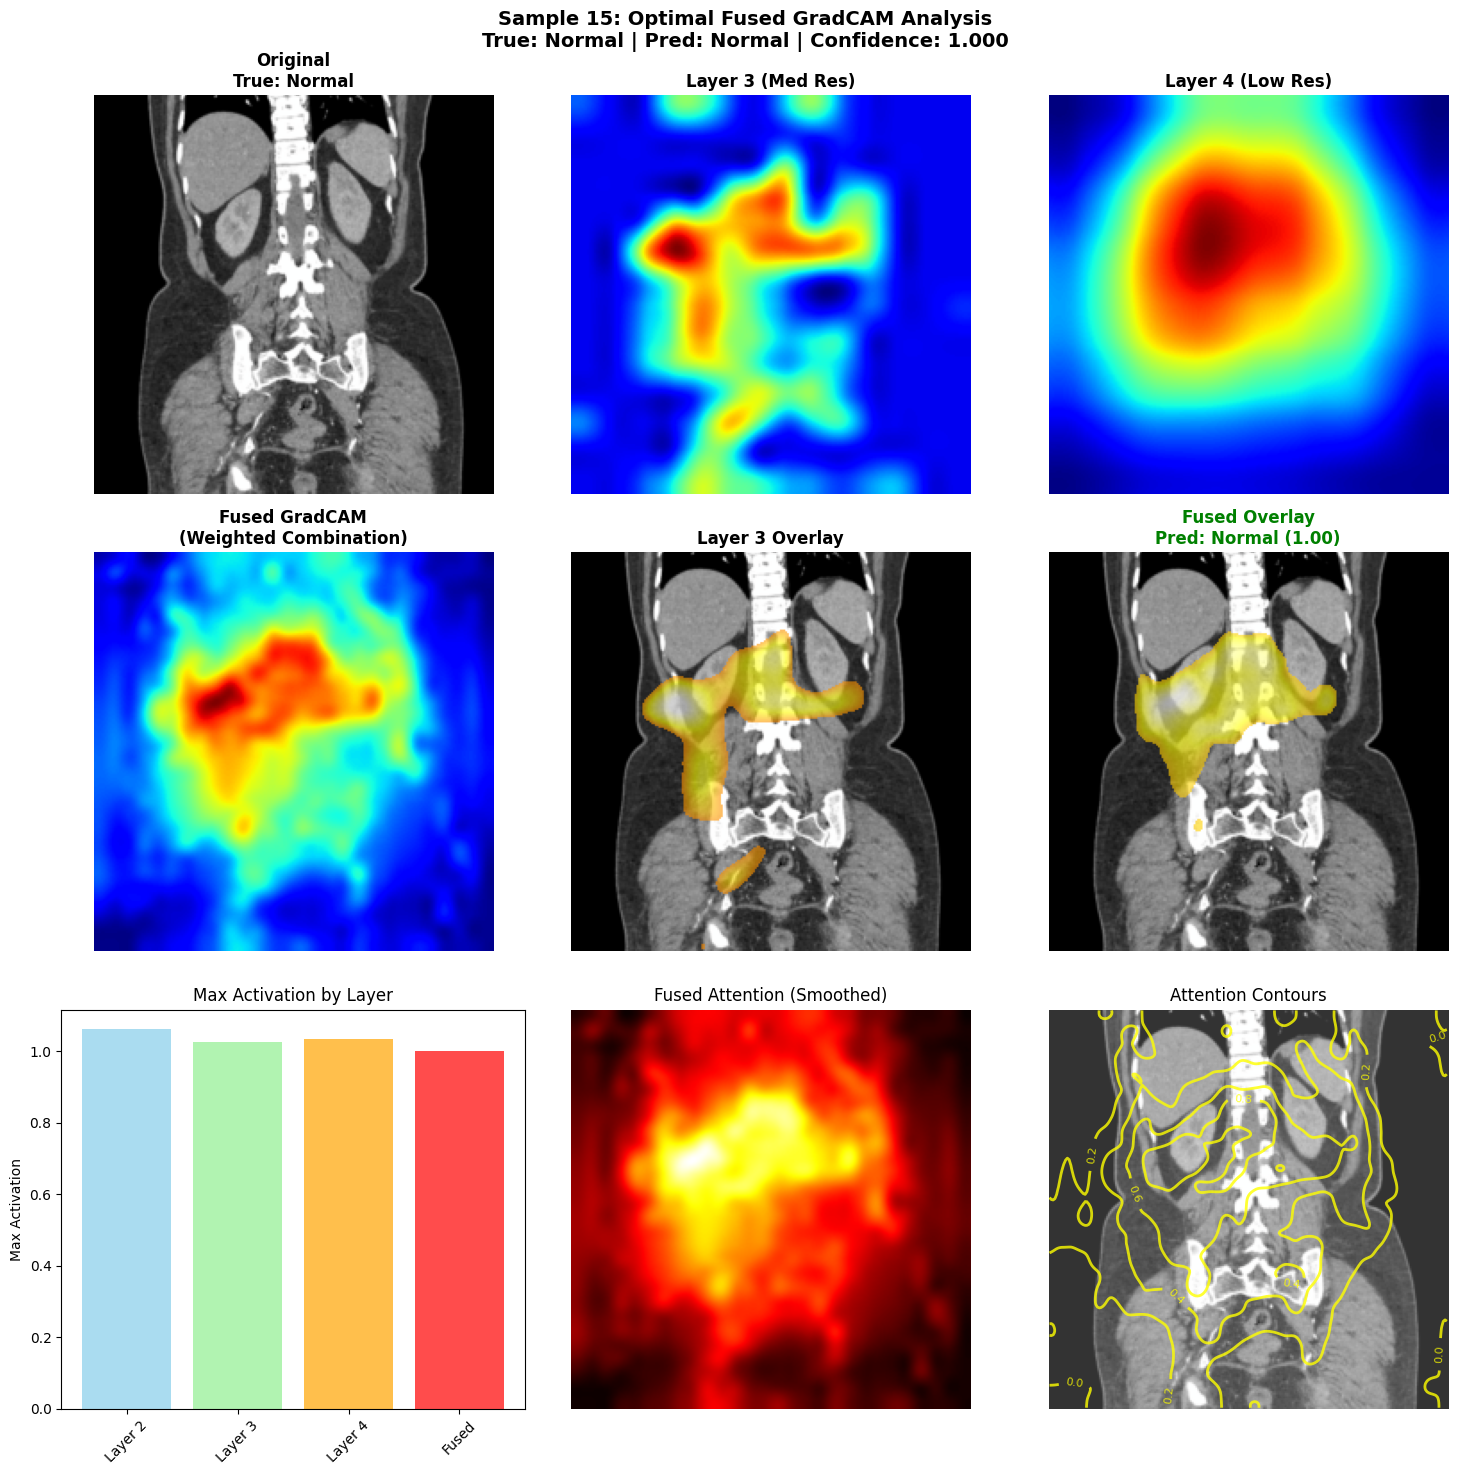


Sample 15 - Detailed Analysis:
  True Label: Normal
  Prediction: Normal (Confidence: 1.000)
  Layer 2 Stats: Max=1.064, Mean=0.169
  Layer 3 Stats: Max=1.027, Mean=0.183
  Layer 4 Stats: Max=1.035, Mean=0.387
  Fused Stats:   Max=1.000, Mean=0.307
  Attention Coverage: Layer3=10.0%, Fused=10.0%
------------------------------------------------------------


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [30]:
create_optimal_fusion_gradcam()

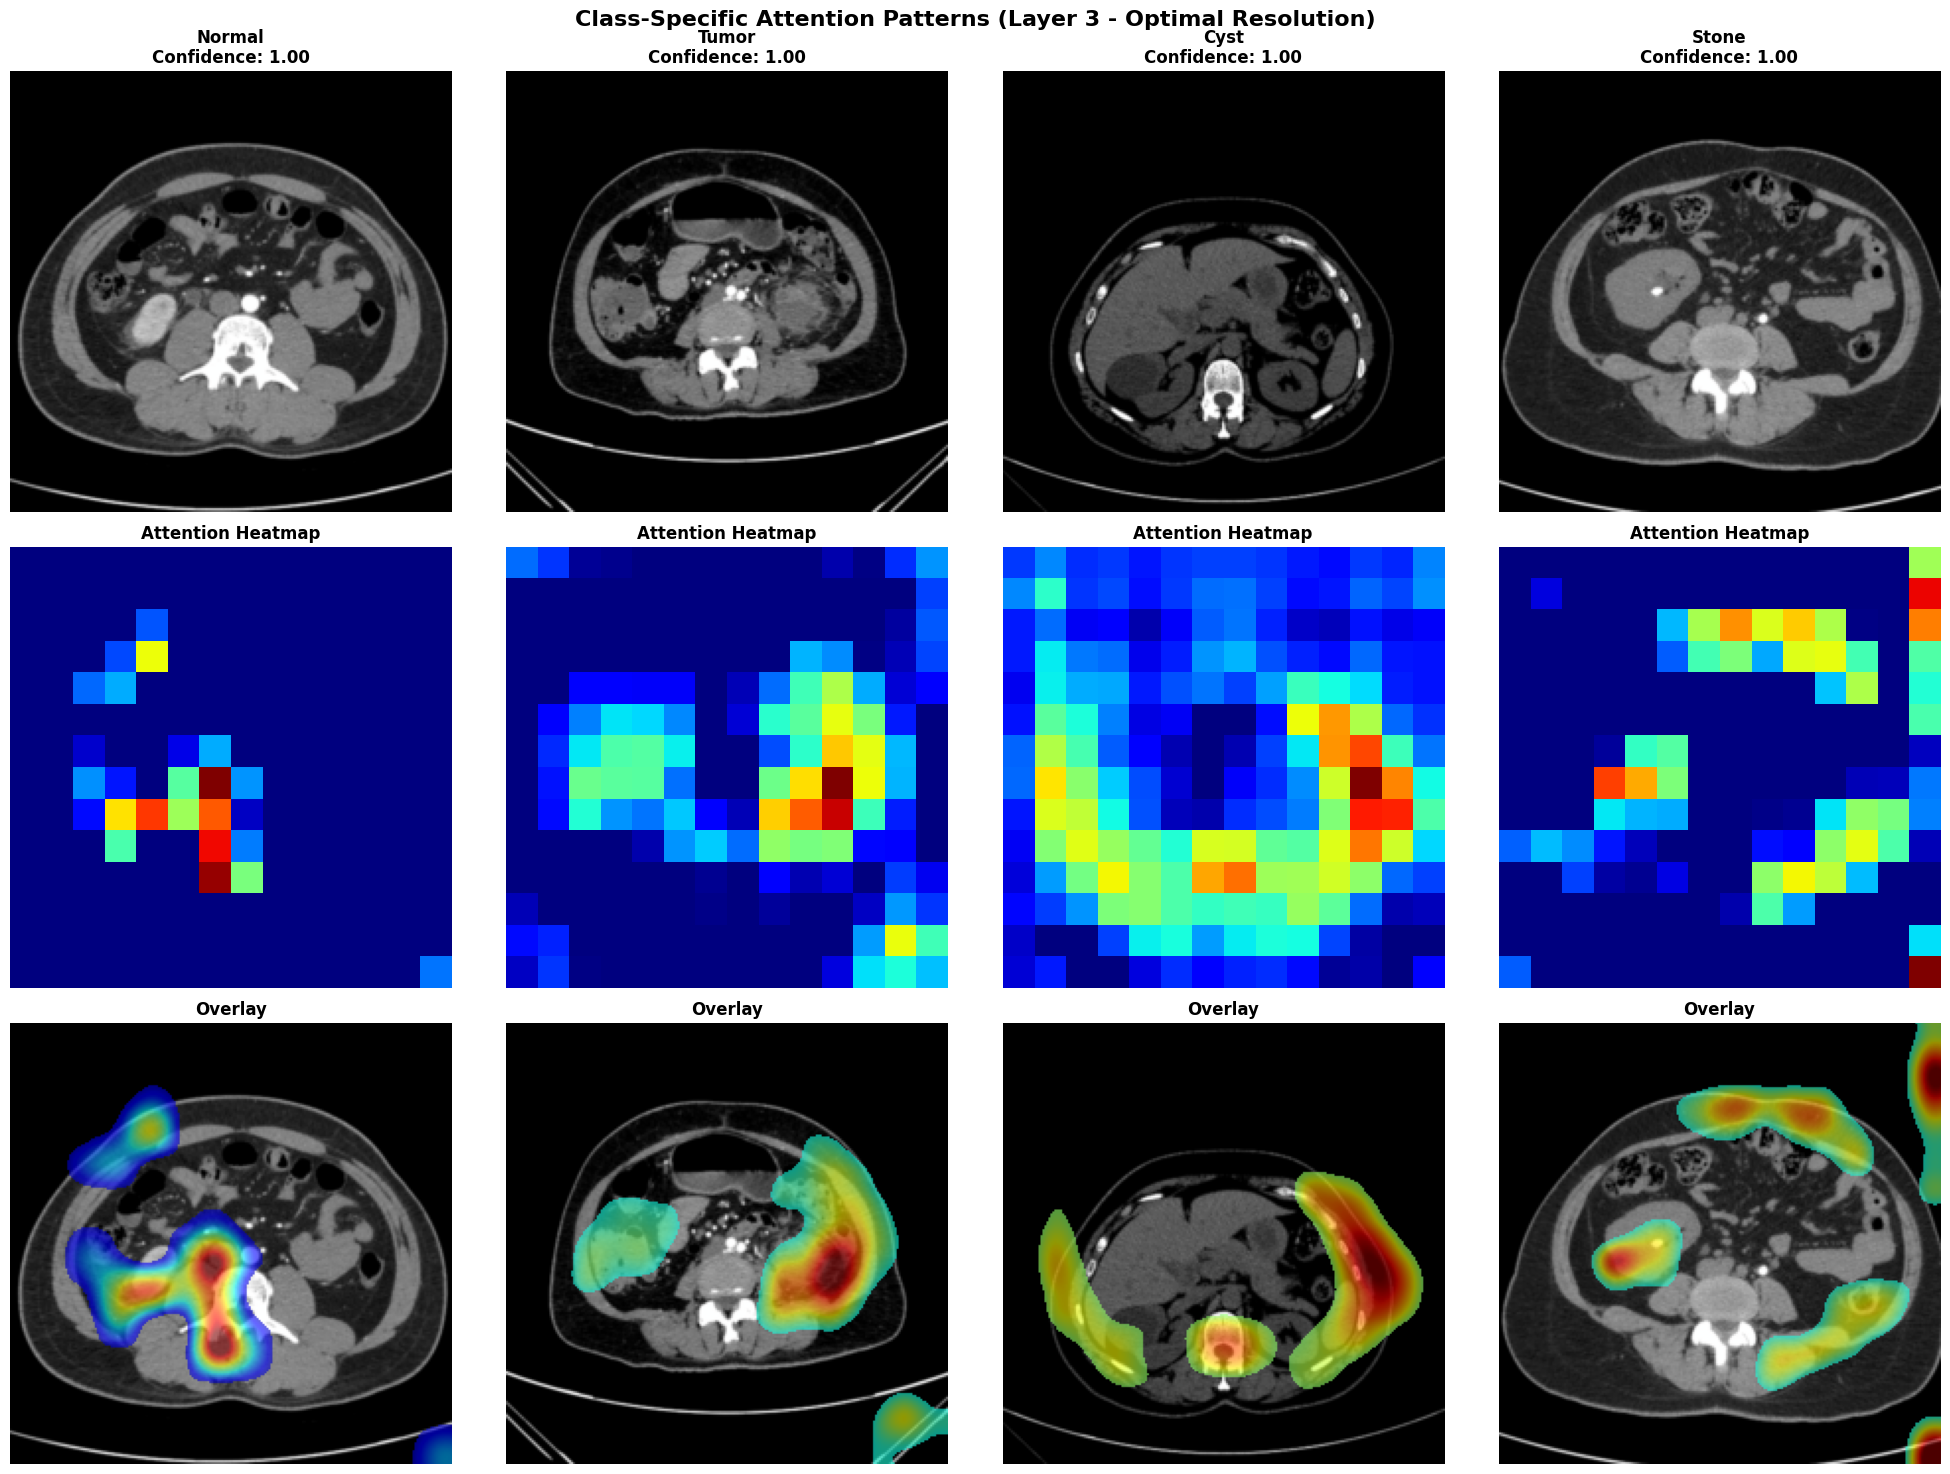


CLASS-SPECIFIC ATTENTION ANALYSIS

Normal:
  Max Activation:  1.000
  Mean Activation: 0.054
  Std Activation:  0.175
  Coverage:        15.0%
  Focus Score:     0.041

Tumor:
  Max Activation:  1.000
  Mean Activation: 0.144
  Std Activation:  0.206
  Coverage:        15.0%
  Focus Score:     0.066

Cyst:
  Max Activation:  1.000
  Mean Activation: 0.280
  Std Activation:  0.209
  Coverage:        15.0%
  Focus Score:     0.179

Stone:
  Max Activation:  1.000
  Mean Activation: 0.126
  Std Activation:  0.225
  Coverage:        15.0%
  Focus Score:     0.112


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [31]:
create_class_comparison_gradcam()